# **Modelling and Evaluation**
---

## Objective

- Answer business requirement 2:
    * The client needs a tool that can tell their pets apart based on live image data.

## Inputs

- The folder `inputs/datasets/pets` containing the subfolders `train`, `test`, and `validation`
- The correctly labelled folders in each of these subfolders
- An adequate amount of preprocessed png images (size 128x128) in each labelled folder, showing a snapshot of a pet coming up to a bowl
- Image shape file

## Outputs

- Images distribution plot in train, validation, and test set
- Image augmentation
- Results of ML hyperparameter optimization
- Machine learning model creation and training
- Saved model that will answer business requirement 2
- Learning curve plot for model performance
- Model evaluation in pickle file
- Prediction on test data
- Prediction on live data
- Score tables for the datasets
- Code for testing model performance during batch classificaion to answer business requirement 3

---
## Preparation

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.preprocessing import image
from PIL import Image
import random
import tensorflow as tf
from colorama import Fore

sns.set_style("white")

### Set the correct working directory

In [2]:
# Check the current working directory; os.chdir to change working directory if needed
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5\\jupyter_notebooks'

In [3]:
# Move up to the project top directory
os.chdir(os.path.dirname(cwd))
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5'

### Set the main paths and constant variables

In [4]:
from src.utils_notebooks import  (print_err, style_dataframe, show_progress,
                                  set_ticks)

dataset_name = "pets"
full_dataset_path = os.path.normpath(os.path.join(cwd,
                                                  "inputs/datasets",
                                                  dataset_name))
output_path = os.path.join(cwd, "outputs")
final_model = os.path.join(output_path, "x_b_1")
train_path = os.path.join(full_dataset_path, "train")
test_path = os.path.join(full_dataset_path, "test")
validation_path = os.path.join(full_dataset_path, "validation")

SAVE = False
INPUT_SHAPE = joblib.load(f"{output_path}/input_shape.pkl")
CLASS_DICT = joblib.load(f"{output_path}/class_dict.pkl")
LABELS = sorted(CLASS_DICT.values())

# The following line should show a list containing the subsets of the split dataset
print(os.listdir(full_dataset_path))

print(INPUT_SHAPE)
print(LABELS)

['test', 'train', 'validation']
(-1, 128, 128, 3)
['fin', 'iris', 'smilla']


--- 
## Step 1: Balance data

In case the dataset is still unbalanced at this point and no more raw data can be collected and added, we can use other methods to balance the labels:
- Use class weights when fitting the model
- Undersample the labels with most data
- Oversample and augment the data

Let's take a look at the current distribution numbers:

### Check label distribution


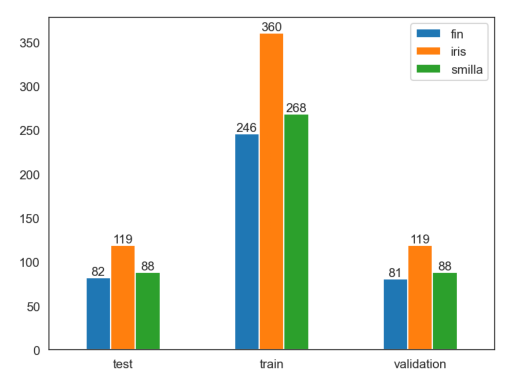

                         TEST        TRAIN   VALIDATION
----------------------------------------------------------------------
fin                        82          246           81
iris                      119          360          119
smilla                     88          268           88


In [108]:
try:
    dataset_stats = joblib.load(f"{output_path}/labels_distribution.pkl")
    dataset_plot = plt.imread(
        f"{output_path}/labels_distribution_after_split.png")
    plt.imshow(dataset_plot)
    plt.axis('off')
    plt.show()
    df = pd.DataFrame(dataset_stats)
    style_dataframe(df)
    
except FileNotFoundError as e:
    print_err(e=e)

### Calculate augmentation values

In this case, we decide to balance the data through augmentation and oversampling.

*Note:*
Should the application of class weights make more sense for a specific dataset, the following code can be run after the creation of the `y_train` variable and added to the `model.fit()` function as the `class_weight` parameter, to be used with a one-hot encoded list of labels:

```python
    from sklearn.utils import class_weight

    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(weights))
```


In [109]:
from sklearn.preprocessing import normalize


def get_augment_amounts(aug_percentage, stats, batch=None):
    """Calculate augment amounts for each label"""
    
    aug_stats = {}
    df = pd.DataFrame(stats)
    print("Current image distribution in the input dataset:\n")

    max_train_amount = df["train"].max() \
        if (not batch or df["train"].max() < batch) else batch
    max_train_label = df["train"].idxmax()

    style_dataframe(df, max_train_label)

    print(f"\nLabel with the most images: {max_train_label} - "
          f"{df['train'].max()} images\n"
    )
    print(f"During the sampling of the original image data, the amount will be"
          f" capped at {Fore.GREEN}{batch}{Fore.RESET}.\n"
    )

    try:
        folders, ratios = joblib.load(f"{output_path}/split_folder_ratio.pkl")
    except FileNotFoundError as e:
        print_err(e=e)

    ratios = normalize([list(ratios)], norm="max").reshape(-1)
    split_ratios = pd.Series(dict(zip(folders, ratios)))
    print(
        f'Normalized split ratios between the train, test, and validation subsets: '
        f'\n{split_ratios.map("{:,.2f}".format).to_string()}'
    )
    max_augment = int(max_train_amount * (1 + aug_percentage))
    print(
        f"\nYou chose to augment the majority label by "
        f"{Fore.GREEN}{aug_percentage*100}%{Fore.RESET}.\n"
        f"After the augmentation, each label in the training set will contain "
        f"{Fore.GREEN}{max_augment}{Fore.RESET} images."
    )

    for col in split_ratios.keys():
        aug_stats[col] = {}
        for idx in df[col].index:
            if batch and df["train"][idx] > batch:
                aug_stats[col][idx] = int(
                    (max_augment - max_train_amount) * split_ratios[col] * -1
                )
            else:
                aug_stats[col][idx] = int(
                    max_augment * split_ratios[col] - df[col][idx]
                )

    print("The following amounts of images need to be added to each label:\n")
    aug_stats = dict(sorted(aug_stats.items(), key=lambda x: x[0]))
    style_dataframe(pd.DataFrame(aug_stats))
    print(
    f"\nIf the amount is negative, the sampling of the original images for "
    f"this label will be \ncapped at {batch} and the label will be augmented "
    f"with the amount shown."
    )

    return aug_stats


`max_label_cap` determines at how many images the collection of original images from a label will be capped.<br>
`aug_percentage` determines by what ratio (scale 0-1) the largest label or the max_label_cap will be augmented.

In [110]:
max_label_cap = 360
aug_stats = get_augment_amounts(aug_percentage=1, stats=dataset_stats,
                                batch=max_label_cap)


Current image distribution in the input dataset:

                         TEST        TRAIN   VALIDATION
----------------------------------------------------------------------
fin                        82          246           81
iris                      119          360          119
smilla                     88          268           88

Label with the most images: iris - 360 images

During the sampling of the original image data, the amount will be capped at 360.

Normalized split ratios between the train, test, and validation subsets: 
train         1.00
test          0.33
validation    0.33

You chose to augment the majority label by 100%.
After the augmentation, each label in the training set will contain 720 images.
The following amounts of images need to be added to each label:

                         TEST        TRAIN   VALIDATION
----------------------------------------------------------------------
fin                       158          474          159
iris           

We visualize the stats for the necessary image augmentations for later reference.

In [111]:

def plot_full_dataset(dataset_stats, aug_stats, LABELS):
    combined_dfs = pd.DataFrame(dataset_stats)
    for label in LABELS:
        if pd.DataFrame(aug_stats).loc[label].any() < 0:
            combined_dfs.loc[label] = abs(pd.DataFrame(aug_stats).loc[label])
    
    aug_stats_abs = {
        k: {l: abs(n) for l, n in v.items()} for k, v in aug_stats.items()
        }
    aug_stats_abs = pd.DataFrame(aug_stats_abs)
    combined_dfs = pd.DataFrame(combined_dfs)

    bar_width = 0.2
    x = np.arange(1, len(LABELS)+1)
    colors = {
        'aug': {k: v for k, v in enumerate(['#4670db', '#d49655', '#6ad94e'])},
        'orig': {k: v for k, v in enumerate(['#2f18db', '#d1791d', '#37c912'])}
        }

    for i in range(len(LABELS)):
        plt.bar(x+bar_width*i,
                combined_dfs[combined_dfs.columns].values[i],
                label=f"{combined_dfs.index[i]} orig",
                width=bar_width,
                color=colors['orig'][i])
        plt.bar(x+bar_width*i,
                aug_stats_abs[aug_stats_abs.columns].values[i], 
                bottom=combined_dfs[combined_dfs.columns].values[i],
                label=f"{aug_stats_abs.index[i]} aug",
                width=bar_width,
                color=colors['aug'][i])
        for ix, val1, val2 in zip(
                            x,
                            combined_dfs[combined_dfs.columns].values[:, i],
                            aug_stats_abs[aug_stats_abs.columns].values[:, i]
                            ):
            plt.text(0.5+bar_width+bar_width/4+bar_width*ix+i, val1, str(val1))
            plt.text(0.5+bar_width+bar_width/4+bar_width*ix+i, val2+val1,
                     str(val2))
        
    plt.xticks([1.2,2.2,3.2], labels=combined_dfs.columns)
    plt.legend()
    SAVE = False
    if SAVE:
        plt.savefig(f'{output_path}/post_augment_dataset_plot.png', dpi=150,
                    bbox_inches='tight')
    plt.show()


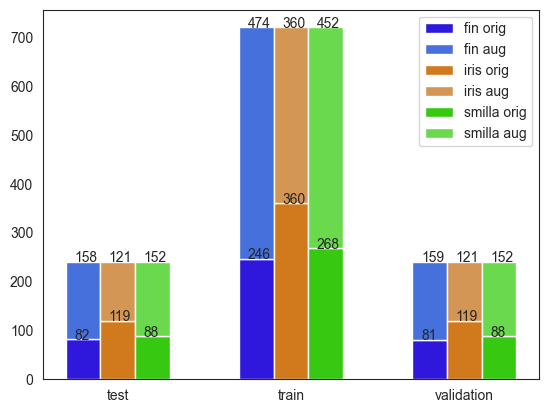

In [112]:
plot_full_dataset(dataset_stats, aug_stats, LABELS)

## Step 2: Load data

We create a function that will handle the augmentation of a label after the original images have been loaded.
<br>
<br>
The attempt to use SMOTENC oversampling to augment the images was not sucessful: The resulting images had too many aberrations from the actual pet form.

In [51]:
from tensorflow.keras.layers import RandomBrightness
import tensorflow as tf


def augment_label(path, subset, extra_amount, X, y, dims, label, img_list):
    """Sample and augment image data"""

    print(f"Adding augmented images for label {label} ...")
    extra_list = np.random.choice(img_list, size=extra_amount, replace=True)
    rand_brightness = RandomBrightness([-0.11, 0.11])
    counters = {"brightness": 0, "crop": 0, "hue": 0}

    list_len = len(extra_list)
    progress_bar = show_progress(list_len)

    for img_name in extra_list:
        img = image.load_img(os.path.join(path, label, img_name))

        brightness_adjust = True if random.random() <= 0.6 else False
        crop_adjust = True if random.random() <= 0.6 else False

        if crop_adjust:
            crop_px = random.randint(5, 10)
            offset = random.randint(-2, 2)
            img = img.crop(
                (
                    crop_px + offset,
                    crop_px + offset,
                    dims[0] - (crop_px - offset),
                    dims[1] - (crop_px - offset),
                )
            )
            counters["crop"] += 1
            img = img.resize(dims, resample=Image.LANCZOS)

        img_arr = image.img_to_array(img)

        # Only the train images will be adjusted with noise,
        # random brightness and hue
        if subset == "train":
            if brightness_adjust:
                img_arr = rand_brightness(img_arr).numpy()
                counters["brightness"] += 1

            if img_arr.max() > 1:
                img_arr = img_arr / 255.0

            # Change hue and add noise for each channel
            # Small std means less noise
            std = 0.03
            mean = 0
            for ch in [0, 1, 2]:
                # Add a layer of random noise to each channel
                gaussian = np.random.normal(mean, std, dims)
                hue_changed = False
                if random.random() < 0.25:
                    # 20% chance of not changing hue, only add noise
                    img_arr[:, :, ch] = np.clip(img_arr[:, :, ch] 
                                                + gaussian, 0, 1)
                    continue

                hue = (
                    random.randrange(-13, 13) / 100.0
                )
                img_flat = img_arr[..., ch].reshape(-1)
                img_hue = np.array([x + hue for x in img_flat]).reshape(dims)
                img_arr[..., ch] = np.clip(img_hue + gaussian, 0, 1)
                hue_changed = True

            if hue_changed:
                counters["hue"] += 1
        else:
            if img_arr.max() > 1:
                img_arr = img_arr / 255.0

        print(next(progress_bar), end="")

        X = np.append(X, img_arr)
        y = np.append(y, label)

    return X, y, counters, list_len

We also create a function to load all images from a specified folder, resize them, add noise to the training set, and save them as np array in X and save their labels in y.

In [52]:
def save_images_in_array(path, subset, aug_stats, max_label_cap, shape):
    """Save images from a folder in a numpy array, save their labels"""

    X, y = np.array([], dtype="int"), np.array([], dtype="object")
    dims = tuple(shape[1:3])

    for label in os.listdir(path):
        print(f"Loading original images for label {label} ...")
        img_list = os.listdir(os.path.join(path, label))
        aug_amount = aug_stats[subset][label]

        try:
            folders, ratios = joblib.load(
                f"{output_path}/split_folder_ratio.pkl")
        except FileNotFoundError as e:
            print_err(e=e)

        ratios = normalize([list(ratios)], norm="max").reshape(-1)
        split_ratios = dict(zip(folders, ratios))
        # Undersample labels that are too large
        if aug_amount < 0:
            img_list = random.sample(
                img_list, k=int(max_label_cap * split_ratios[subset])
            )

        list_len = len(img_list)
        progress_bar = show_progress(list_len)

        for img_name in img_list:
            img = image.load_img(os.path.join(path, label, img_name))
            img_arr = image.img_to_array(img)
            if img_arr.max() > 1:
                img_arr = img_arr / 255.0

            # Add noise to train image set
            if subset == "train":
                std = 0.03
                mean = 0
                gaussian = np.random.normal(mean, std, dims)
                noisy_image = np.zeros(img_arr.shape, np.float32)
                for ch in [0, 1, 2]:
                    noisy_image[:, :, ch] = img_arr[:, :, ch] + gaussian
                img_arr = np.clip(noisy_image, 0, 1).astype(np.float32)

            print(next(progress_bar), end="")

            X = np.append(X, img_arr)
            y = np.append(y, label)

        print(f"{list_len} images loaded")

        # Augment images:
        X, y, counters, aug_count = augment_label(
            path, subset, abs(aug_amount), X, y, dims, label, img_list
        )

        print(f"{aug_count} images loaded")

        print(
            f'\nAugmented label {label} by cropping {counters["crop"]} images,'
            f' adjusting brightness for {counters["brightness"]} images and '
            f'\nchanging hue for {counters["hue"]} images. '
            f'{"Noise has been added to all images." if subset == "train" else ""}'
        )
        print(
            f"The {subset} subset for {label} contains {list_len + aug_count} "
            f"images.\n"
        )

    X = X.reshape(shape)


    # Shuffle the resulting set
    zipped_set = list(zip(y, X))
    random.shuffle(zipped_set)
    y_shuffled, X_shuffled = list(map(list, zip(*zipped_set)))
    X = np.array(X_shuffled, dtype="float")
    y = np.array(y_shuffled, dtype="object")

    print(f"Resulting image set shape: {X.shape}, {y.shape} labels\n")

    return X, y

### Load train set

In [53]:
X_train, y_train = save_images_in_array(
    train_path, "train", aug_stats, max_label_cap, INPUT_SHAPE
)

Loading original images for label fin ...
: ####################################################################################################|| 100 images loaded
Adding augmented images for label fin ...
: ####################################################################################################|| 30 images loaded

Augmented label fin by cropping 16 images, adjusting brightness for 18 images and 
changing hue for 18 images. Noise has been added to all images.
The train subset for fin contains 130 images.

Loading original images for label iris ...
: ####################################################################################################|| 100 images loaded
Adding augmented images for label iris ...
: ####################################################################################################|| 30 images loaded

Augmented label iris by cropping 23 images, adjusting brightness for 17 images and 
changing hue for 22 images. Noise has been added to all imag

#### Save train set shape

In [64]:
joblib.dump(X_train.shape, f"{output_path}/input_shape_loaded.pkl")

['d:\\Projekte\\Coding\\CodeInstitute\\PP5\\outputs/input_shape_loaded.pkl']

#### Show montage

In [67]:
import itertools


def show_subset_montage(X, y, subset, save=False):
    # Display a random batch of k images from the newly created subset
    img_sample = random.sample(range(0, X.shape[0]), k=9)
    coords = list(itertools.product(range(3), range(3)))
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    for coord, idx in zip(coords, list(img_sample)):
        axes[coord[0], coord[1]].set_title(y[idx])
        axes[coord[0], coord[1]].imshow(X[idx])
        set_ticks(axes[coord[0], coord[1]])
    plt.tight_layout(rect=[0, 0.02, 0.9, 0.97])
    if save:
        plt.savefig(
            f"{output_path}/post_augment_montage_{subset}.png",
            bbox_inches="tight",
            dpi=150,
        )
    plt.show()

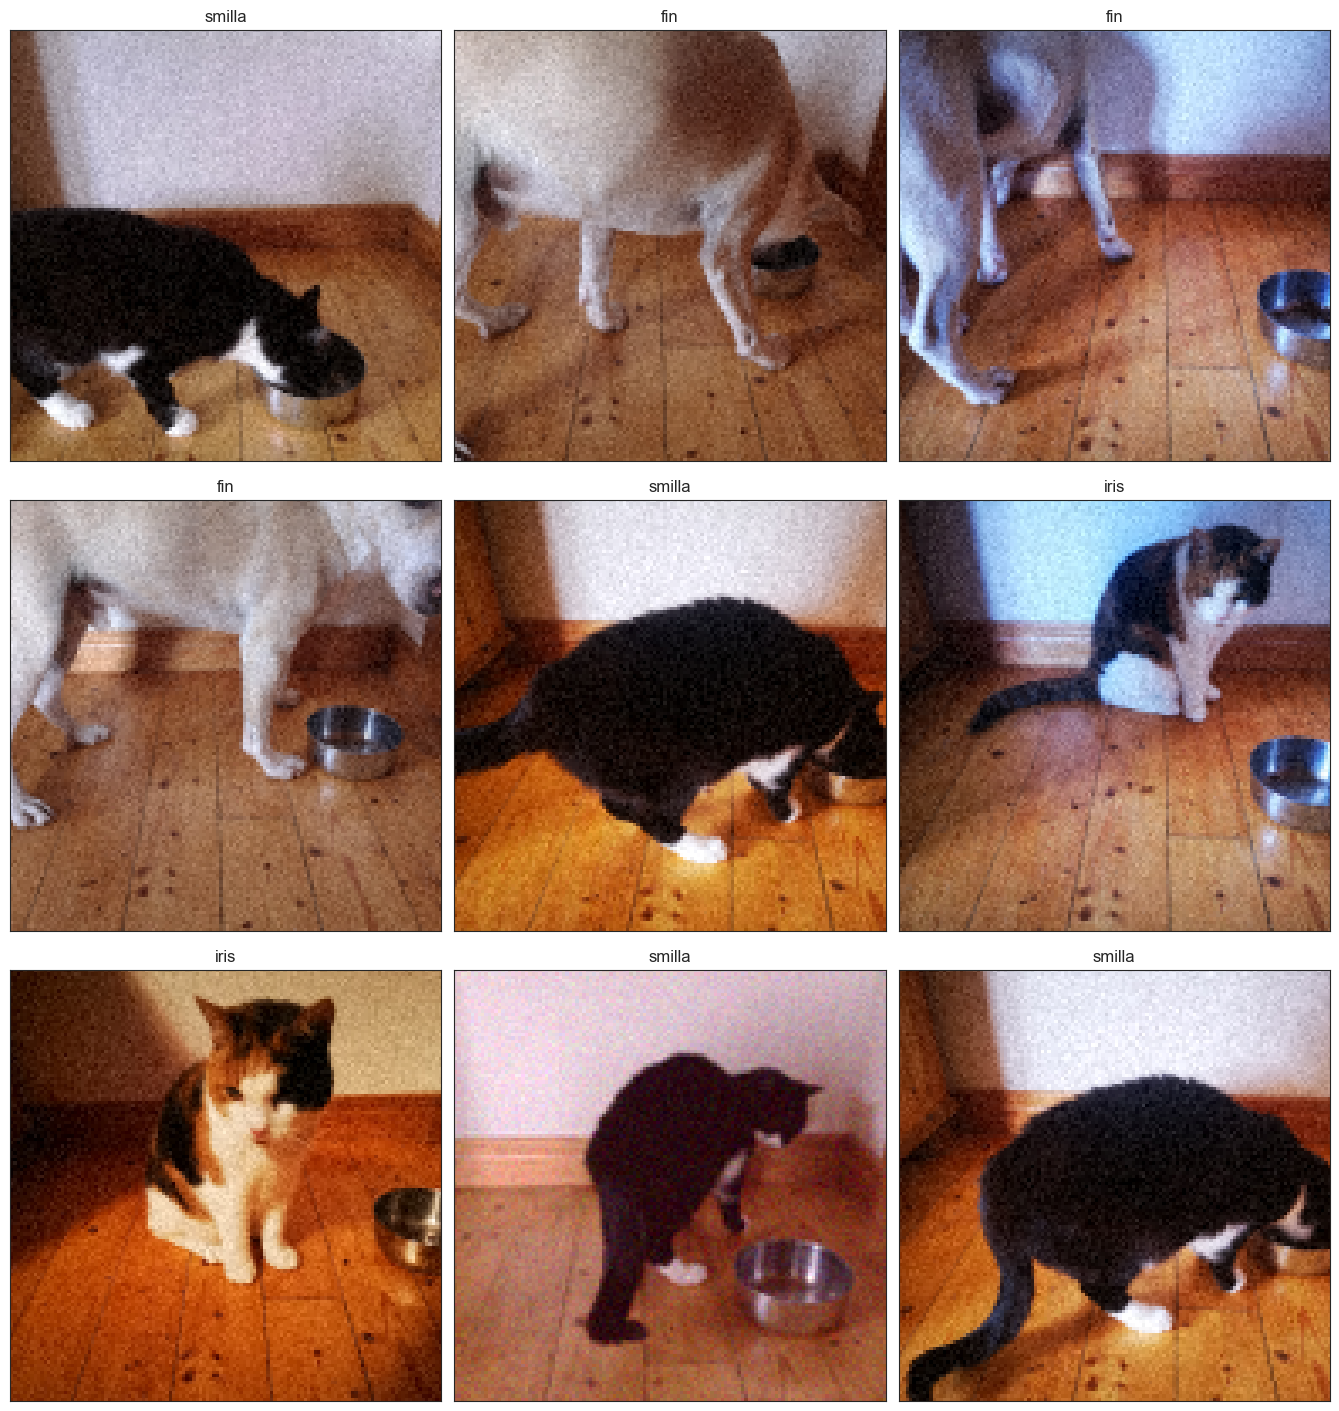

In [68]:
show_subset_montage(X_train, y_train, "train")

### Load all other subsets

In [69]:
X_test, y_test = save_images_in_array(
    test_path, "test", aug_stats, max_label_cap, INPUT_SHAPE
)
X_val, y_val = save_images_in_array(
    validation_path, "validation", aug_stats, max_label_cap, INPUT_SHAPE
)

Loading original images for label fin ...
: ####################################################################################################|| 82 images loaded
Adding augmented images for label fin ...
: ####################################################################################################|| 158 images loaded

Augmented label fin by cropping 101 images, adjusting brightness for 0 images and 
changing hue for 0 images. 
The test subset for fin contains 240 images.

Loading original images for label iris ...
: ####################################################################################################|| 119 images loaded
Adding augmented images for label iris ...
: ####################################################################################################|| 121 images loaded

Augmented label iris by cropping 65 images, adjusting brightness for 0 images and 
changing hue for 0 images. 
The test subset for iris contains 240 images.

Loading original image

#### Show montages

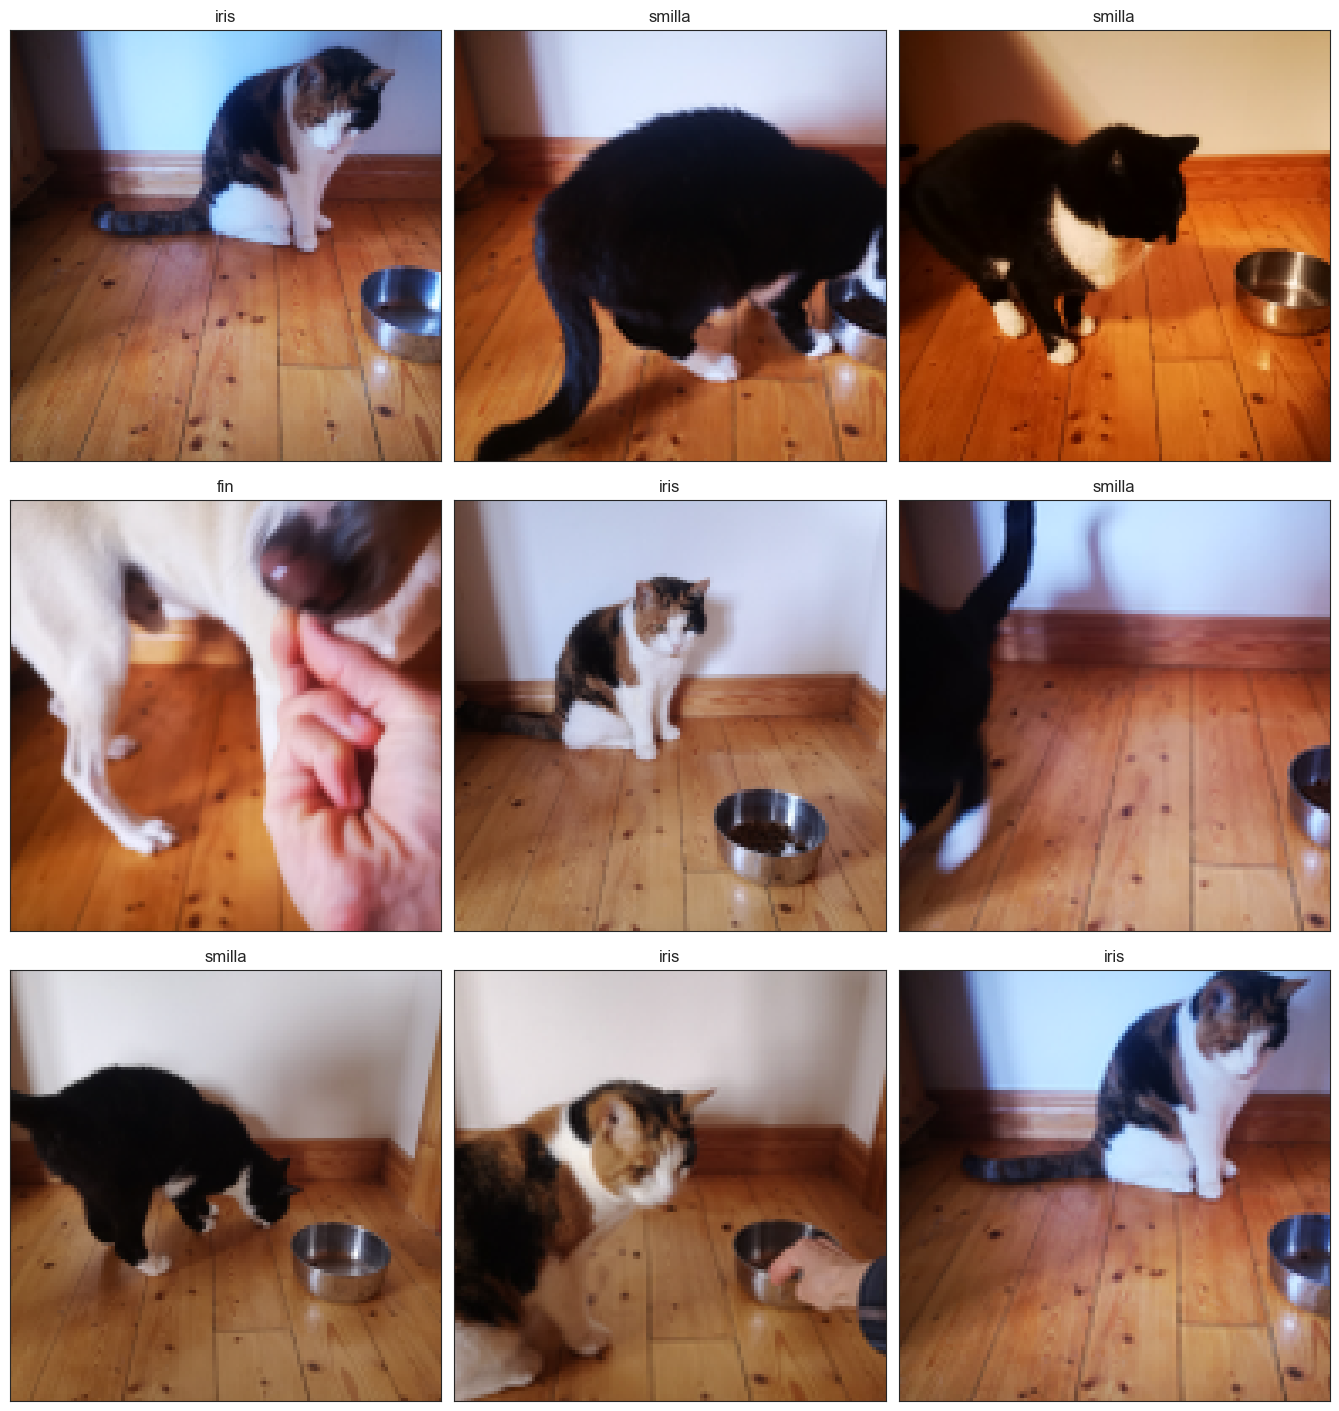

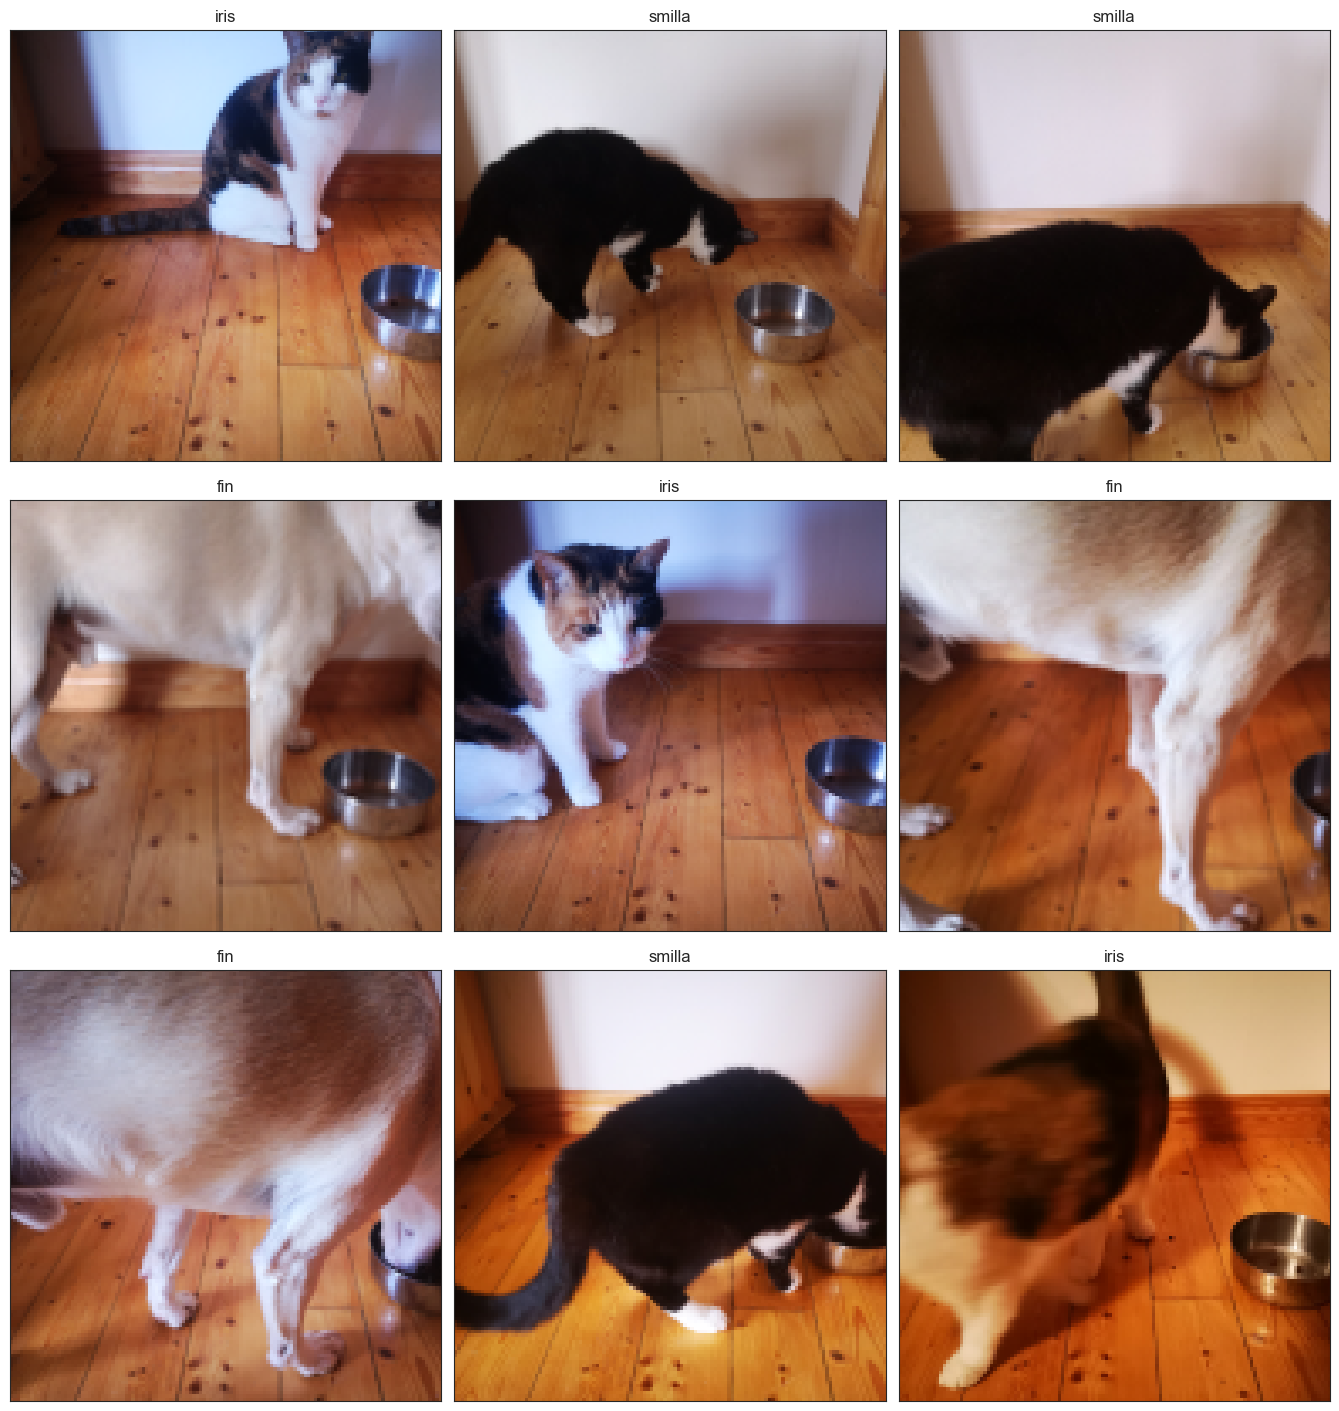

In [70]:
# Display a random batch of k images from the newly created validation and test sets
show_subset_montage(X_val, y_val, "val")
show_subset_montage(X_test, y_test, "test")

### One-hot encode all label arrays

In [71]:
y_ohe_train = pd.get_dummies(y_train, dtype="int")
y_ohe_test = pd.get_dummies(y_test, dtype="int")
y_ohe_val = pd.get_dummies(y_val, dtype="int")

# Check if the encoding has succeeded
print(y_ohe_train.head())
print(y_ohe_test.head())
print(y_ohe_val.head())

# Save the one-hot encoded categories for later use
ohe_enc = pd.get_dummies(LABELS, dtype="int")
ohe_map = {}
for idx, label in CLASS_DICT.items():
    ohe_map[label] = list(ohe_enc.iloc[idx])
joblib.dump(ohe_map, f"{output_path}/ohe_map.pkl")
print(ohe_map)

   fin  iris  smilla
0    0     1       0
1    0     1       0
2    0     0       1
3    0     1       0
4    0     1       0
   fin  iris  smilla
0    1     0       0
1    0     1       0
2    1     0       0
3    0     0       1
4    1     0       0
   fin  iris  smilla
0    1     0       0
1    1     0       0
2    1     0       0
3    0     1       0
4    0     0       1
{'fin': [1, 0, 0], 'iris': [0, 1, 0], 'smilla': [0, 0, 1]}


### (Optional) Save and load subsets

#### Save subsets and labels to files

In [71]:
v = ''

def save_subsets_and_labels(X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val):
    joblib.dump(X_train, f"{output_path}/X_train_{v}.pkl")
    joblib.dump(X_test, f"{output_path}/X_test_{v}.pkl")
    joblib.dump(X_val, f"{output_path}/X_val_{v}.pkl")
    joblib.dump(y_ohe_train, f"{output_path}/y_ohe_train_{v}.pkl")
    joblib.dump(y_ohe_test, f"{output_path}/y_ohe_test_{v}.pkl")
    joblib.dump(y_ohe_val, f"{output_path}/y_ohe_val_{v}.pkl")


save_subsets_and_labels(X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val)

#### Load subsets and labels from files

In [12]:
# Load the image sets and OHE labels into memory if they already have been created:

def load_subsets_and_labels():
    v = ''
    X_train = joblib.load(f"{output_path}/X_train_{v}.pkl")
    X_test = joblib.load(f"{output_path}/X_test_{v}.pkl")
    X_val = joblib.load(f"{output_path}/X_val_{v}.pkl")
    y_ohe_train = joblib.load(f"{output_path}/y_ohe_train_{v}.pkl")
    y_ohe_test = joblib.load(f"{output_path}/y_ohe_test_{v}.pkl")
    y_ohe_val = joblib.load(f"{output_path}/y_ohe_val_{v}.pkl")

    return X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val


X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val = load_subsets_and_labels()

## Step 3: Build the model

In [74]:
import tensorflow as tf
import keras_tuner
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dropout,
    Flatten,
    Dense,
    Conv2D,
    MaxPooling2D,
    InputLayer,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

We set various value ranges for the tuner to test.

In [73]:
def test_model(hp):

    img_shape = (128, 128, 3)
    output_classes = 3
    hp_kernel_reg = hp.Choice("kernel_reg", values=[0.0, 1e-1, 1e-2,
                                                    1e-3, 1e-4])

    model = Sequential()
    model.add(InputLayer(shape=img_shape))

    kern = hp.Int("kernel_1", min_value=3, max_value=6, step=1)
    model.add(
        Conv2D(
            filters=hp.Int("filters_1", min_value=32, max_value=256, step=32),
            kernel_size=(kern, kern),
            padding="same",
            activation="relu",
            kernel_regularizer=l2(hp_kernel_reg),
        )
    )
    pool = hp.Int("pool_1", min_value=2, max_value=5, step=1)
    model.add(MaxPooling2D(pool_size=(pool, pool)))

    model.add(
        Conv2D(
            filters=hp.Int("filters_2", min_value=64, max_value=256, step=32),
            kernel_size=(3, 3),
            padding="same",
            activation="relu",
            kernel_regularizer=l2(hp_kernel_reg),
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Optional third filter layer
    for i in range(0, hp.Int("third_filter", 0, 1)):
        model.add(
            Conv2D(
                filters=hp.Int(
                    "filters_3", min_value=128, max_value=256, step=32
                ),
                kernel_size=(3, 3),
                padding="same",
                activation="relu",
                kernel_regularizer=l2(hp_kernel_reg),
            )
        )
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(
        Dense(
            hp.Int("dense_units_1", min_value=128, max_value=1024, step=64),
            activation="relu",
        )
    )
    model.add(Dropout(hp.Float("dropout_1", min_value=0.2, max_value=0.6,
                               step=0.1)))

    # Optional second dense layer
    for i in range(0, hp.Int("second_dense_layer", 0, 1)):
        model.add(
            Dense(
                hp.Int("dense_units_2", min_value=64, max_value=256, step=32),
                activation="relu",
                kernel_regularizer=l2(hp_kernel_reg),
            )
        )
        model.add(
            Dropout(hp.Float("dropout_2", min_value=0.2, max_value=0.5,
                             step=0.1))
        )

    model.add(Dense(output_classes, activation="softmax"))

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-1, 1e-2,
                                                          1e-3, 1e-4])
    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=["accuracy"],
    )

    model.summary()

    return model

### Tune model

In [123]:
early_stop = EarlyStopping(monitor="val_loss", patience=5,
                           restore_best_weights=True, 
                           start_from_epoch=5,)

hp = keras_tuner.HyperParameters()
model = test_model(hp)

batch_size = 32

tuner = keras_tuner.BayesianOptimization(
    test_model,
    max_trials=20,
    objective="val_accuracy",
    directory="/tmp/tb",
    project_name="pets",
)

tuner.search(
    X_train,
    y_ohe_train,
    validation_data=(X_val, y_ohe_val),
    epochs=30,
    batch_size=batch_size,
    callbacks=[early_stop],
)

Trial 1 Complete [00h 03m 45s]
val_accuracy: 0.9558498859405518

Best val_accuracy So Far: 0.9558498859405518
Total elapsed time: 00h 03m 45s


### Save hyperparameters

In [18]:
best_model = tuner.get_best_models(num_models=1)[0]

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
hyperparams = best_hyperparameters.values
joblib.dump(hyperparams, f'{final_model}/hyperparam_values_{v}.pkl')
print(pd.Series(hyperparams).to_string())

kernel_1           5.0000
filters_1        128.0000
pool_1             6.0000
filters_2        128.0000
filters_3        128.0000
dense_units_1    384.0000
dropout_1          0.3000
learning_rate      0.0010
kernel_reg         0.0001


### (Optional) Load pre-saved hyperparameter values

In [26]:
hyperparams = joblib.load(f"{final_model}/hyperparam_values_{v}.pkl")
print(pd.Series(hyperparams))

kernel_1           6.000
filters_1        128.000
pool_1             5.000
filters_2        128.000
num_filters        1.000
dense_units_1    384.000
dropout_1          0.600
learning_rate      0.001
filters_3_0      128.000
dtype: float64


## Step 4: Train the model

### Adapt and compile model

In [321]:
def create_model(hyperparams):
    img_shape = INPUT_SHAPE[1:]
    output_classes = len(LABELS)

    model = Sequential()
    model.add(InputLayer(shape=img_shape))

    model.add(
        Conv2D(
            filters=hyperparams["filters_1"],
            kernel_size=(hyperparams["kernel_1"],
                         hyperparams["kernel_1"]),
            activation="relu",
            padding='same',
            kernel_regularizer=l2(hyperparams['kernel_reg']),
        )
    )
    model.add(MaxPooling2D(pool_size=(hyperparams["pool_1"],
                                      hyperparams["pool_1"])))

    model.add(
        Conv2D(
            filters=hyperparams["filters_2"],
            kernel_size=(3, 3),
            activation="relu",
            padding='same',
            kernel_regularizer=l2(hyperparams['kernel_reg']),
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(
        Conv2D(
            filters=hyperparams["filters_3"],
            kernel_size=(3, 3),
            activation="relu",
            padding='same',
            kernel_regularizer=l2(hyperparams['kernel_reg']),
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(hyperparams["dense_units_1"],
                    activation="relu",
                    kernel_regularizer=l2(hyperparams['kernel_reg'])))
    model.add(Dropout(hyperparams["dropout_1"]))

    model.add(Dense(output_classes, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(
            learning_rate=hyperparams["learning_rate"]),
        metrics=["accuracy"],
    )

    model.summary()

    return model

### Fit the model

In [340]:
early_stop = EarlyStopping(monitor="val_loss", patience=5,
                           restore_best_weights=True,
                           start_from_epoch=5,)

batch_size = 32

model = create_model(hyperparams)

history = model.fit(
    X_train,
    y_ohe_train,
    epochs=40,
    validation_data=(X_val, y_ohe_val),
    verbose=1,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[early_stop]
)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 128)  │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 384)            │     1,769,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,072,451 (7.91 MB)

 Trainable params: 2,072,451 (7.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 665ms/step - accuracy: 0.5191 - loss: 0.9934 - val_accuracy: 0.9133 - val_loss: 0.2912
Epoch 2/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 620ms/step - accuracy: 0.9248 - loss: 0.2910 - val_accuracy: 0.9467 - val_loss: 0.1736
Epoch 3/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 613ms/step - accuracy: 0.9478 - loss: 0.1868 - val_accuracy: 0.9750 - val_loss: 0.1285
Epoch 4/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 666ms/step - accuracy: 0.9714 - loss: 0.1337 - val_accuracy: 0.9583 - val_loss: 0.1437
Epoch 5/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 733ms/step - accuracy: 0.9864 - loss: 0.0908 - val_accuracy: 0.9467 - val_loss: 0.1719
Epoch 6/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 681ms/step - accuracy: 0.9887 - loss: 0.0767 - val_accuracy: 0.9450 - val_loss: 0.1669
Epoch 7/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 657ms/step - accuracy: 0.9952 - loss: 0.0576 - val_accuracy: 0.9650 - val_loss: 0.1766
Epoch 8/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 662ms/step - accuracy: 0.9913 - loss: 0.0705 - val_accu

### Identify best epoch

In [386]:
val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f"Best epoch: {best_epoch}")

Best epoch: 7


### Retrain model

If the last epoch was not the best, retrain the model and stop at the best epoch.

In [ ]:
print(joblib.load(f'{output_path}/hyperparam_values.pkl'))

In [343]:
model = create_model(hyperparams)

history = model.fit(
    X_train,
    y_ohe_train,
    epochs=best_epoch,
    validation_data=(X_val, y_ohe_val),
    verbose=1,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[early_stop]
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 128)  │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 384)            │     1,769,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │         1,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,072,451 (7.91 MB)

 Trainable params: 2,072,451 (7.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 704ms/step - accuracy: 0.5687 - loss: 0.9386 - val_accuracy: 0.8883 - val_loss: 0.3572
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 622ms/step - accuracy: 0.9208 - loss: 0.3075 - val_accuracy: 0.9600 - val_loss: 0.1892
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 621ms/step - accuracy: 0.9599 - loss: 0.1639 - val_accuracy: 0.9650 - val_loss: 0.1463
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 640ms/step - accuracy: 0.9847 - loss: 0.0946 - val_accuracy: 0.9750 - val_loss: 0.1123
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 704ms/step - accuracy: 0.9888 - loss: 0.0876 - val_accuracy: 0.9767 - val_loss: 0.0973
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 699ms/step - accuracy: 0.9932 - loss: 0.0687 - val_accuracy: 0.9633 - val_loss: 0.1240
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 766ms/step - accuracy: 0.9899 - loss: 0.0771 - val_accuracy: 0.9850 - val_loss: 0.0980
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 778ms/step - accuracy: 0.9996 - loss: 0.0549 - val_accu

### Save the model

IMPORTANT! Make sure to set a new version name.

In [344]:
v = ' '
model.save(f"{output_path}/model_final_{v}.keras")

### (Optional) Load pre-saved model

In [60]:
v = '_x_b_1'
model = tf.keras.models.load_model(f"{final_model}/model_final_x_b_1.keras")

If necessary, the model can be converted to tflite and shrink in size. However, tflite models can not be retrained, they are only useful for inference.

In [26]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_path = f'{final_model}/model_x_b_1.tflite'
# Save the TFLite model as a .tflite file
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Public\Documents\Wondershare\CreatorTemp\tmp5rtwv355\assets


INFO:tensorflow:Assets written to: C:\Users\Public\Documents\Wondershare\CreatorTemp\tmp5rtwv355\assets


Saved artifact at 'C:\Users\Public\Documents\Wondershare\CreatorTemp\tmp5rtwv355'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_16')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1473305798096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1473305797520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1473305794640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1473305800208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1472054067856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1473305795408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1473298374608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1473299328720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1472064928272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1472063406160: TensorSpec(shape=(), dtype=tf.resource, 

In [75]:
# Load TFLite model and allocate tensors
tflite_path = f'{final_model}/model_x_b_1.tflite'

interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = input_details[0]['index']
output_index = output_details[0]['index']
int_data = (interpreter, input_index, output_index)

This function initializes the interpreter for use with tflite models.<br>
It can be called as follows:<br>
`y_pred = tflite_predict(sample_imgs, *int_data)`

In [76]:
def tflite_predict(imgs, interpreter, input_index, output_index):

    y_pred_raw = np.array([])
    for img in imgs:
        input_data = np.expand_dims(img.astype('float32'), axis=0)
        interpreter.set_tensor(input_index, input_data)

        interpreter.invoke()
        output_data = interpreter.get_tensor(output_index)

        if len(y_pred_raw) == 0:
            y_pred_raw = output_data
        else:
            y_pred_raw = np.vstack((y_pred_raw, output_data))

    return y_pred_raw

## Step 5: Evaluate model

### Compare losses and accuracy

In [ ]:
losses = pd.DataFrame(history.history)

sns.set_style("whitegrid")
losses[["loss", "val_loss"]].plot(style=".-")
plt.title("Loss")

if SAVE:
    plt.savefig(f"{output_path}/model_losses_{v}.png", bbox_inches="tight", dpi=150)
plt.show()

print("\n")
losses[["accuracy", "val_accuracy"]].plot(style=".-")
plt.title("Accuracy")

if SAVE:
    plt.savefig(f"{output_path}/model_acc_{v}.png", bbox_inches="tight", dpi=150)
plt.show()

### Evaluate based on test subset

In [ ]:
eval = model.evaluate(X_test, y_ohe_test, verbose=2)
eval

In [372]:
joblib.dump(eval, f"{final_model}/model_final_eval_{v}.pkl")

[0.10516383498907089, 0.9850000143051147]

## Step 6: Make predictions
### Predict classes for a test image sample

To use a keras model for predictions:<br>
  `y_pred = model.predict(sample_imgs, verbose=3)`<br>
To use a tflite model:<br>
  `y_pred = tflite_predict(sample_imgs, *int_data)`<br>

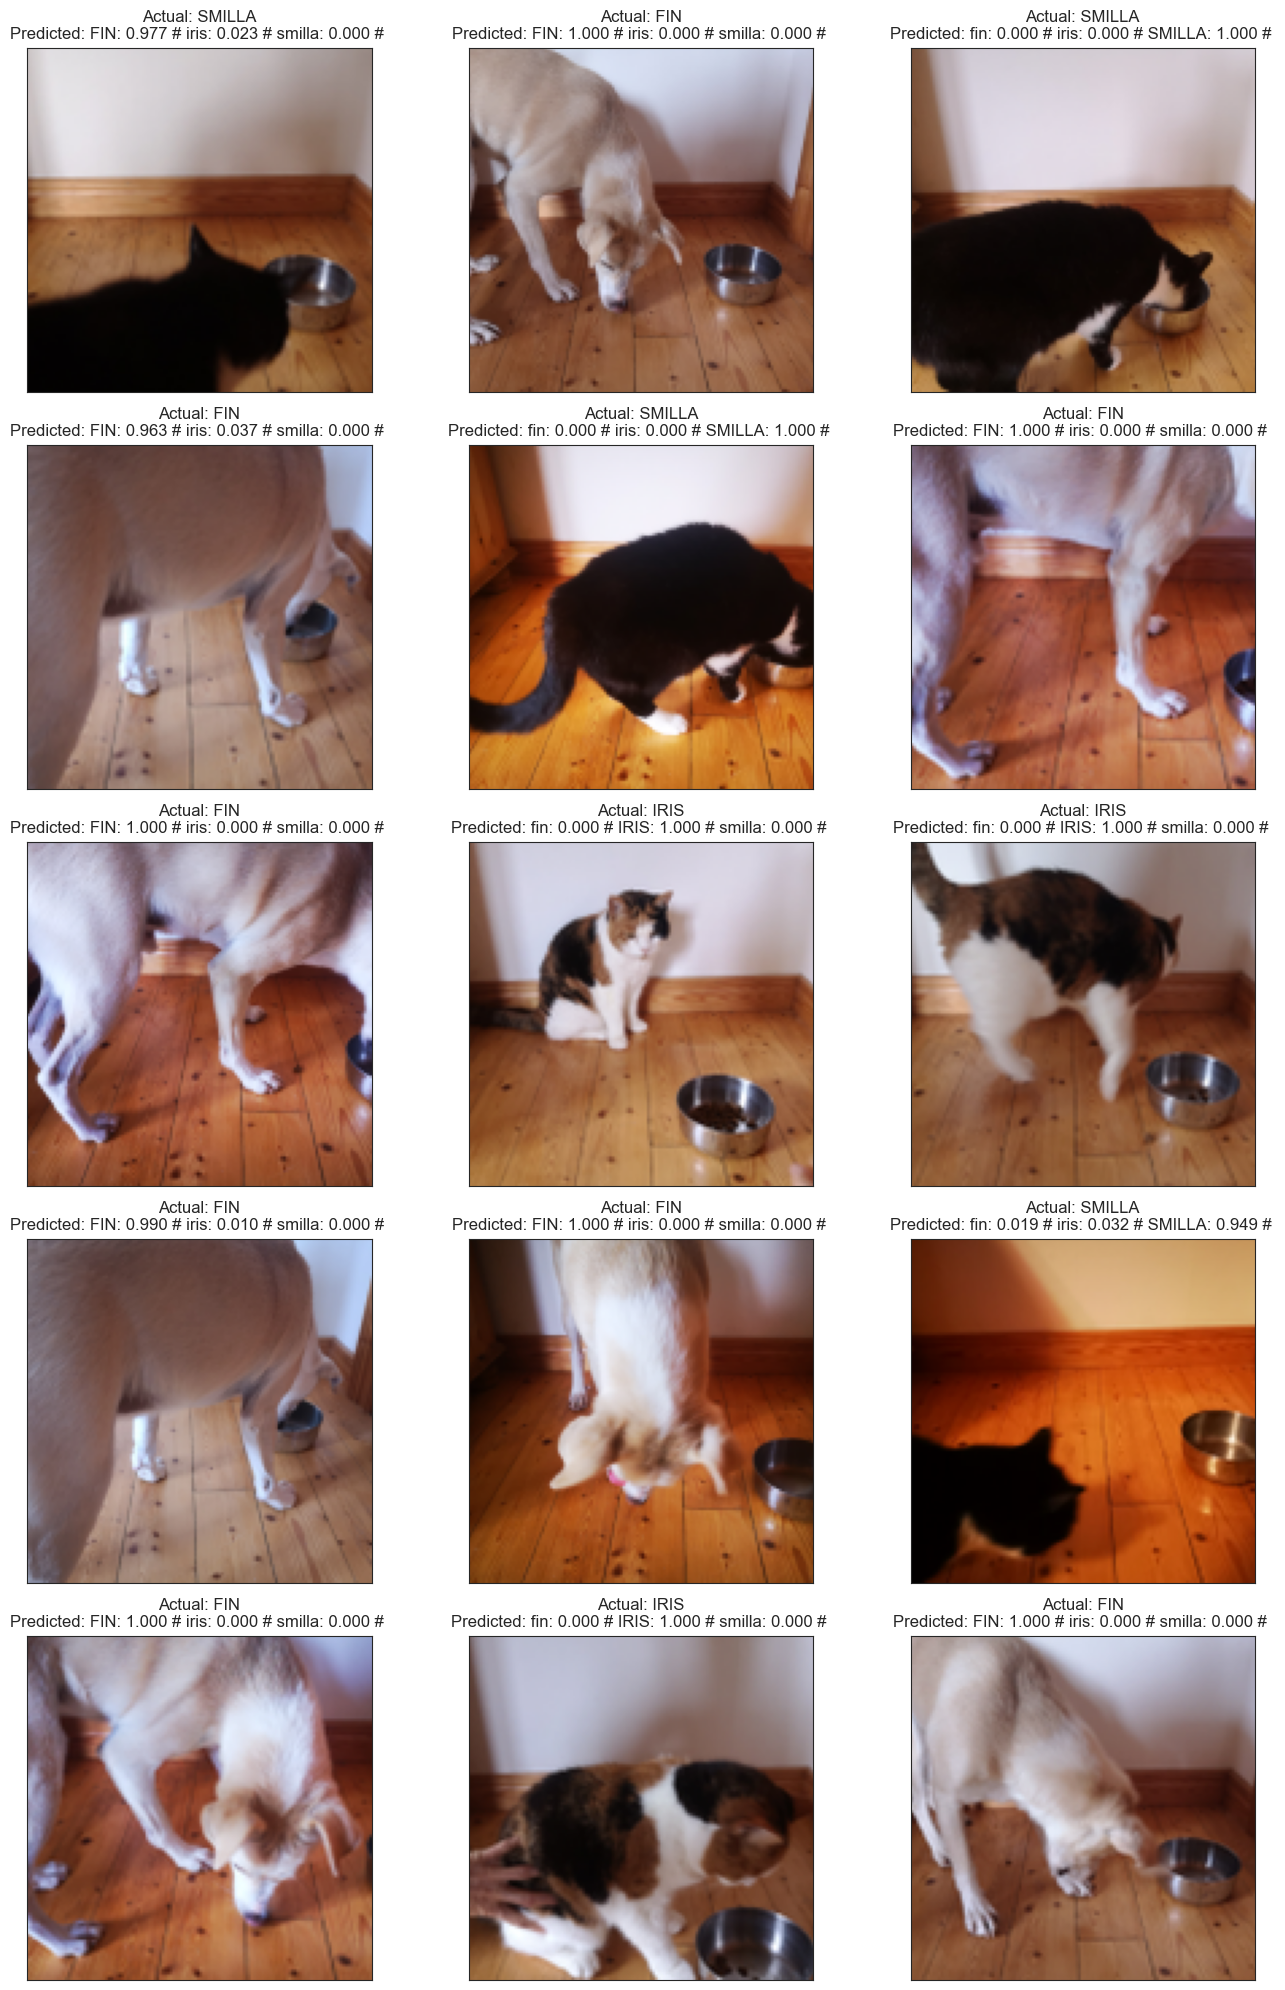

In [78]:
import itertools
sns.set_style("white")
# Note: sample amount must be divisible by 3 to fit into three columns
SAMPLE_AMOUNT = 15
nrows = SAMPLE_AMOUNT // 3
coords = itertools.product(range(nrows), range(3))
# Sample random images and assign correct labels
img_idx = random.sample(range(0, X_test.shape[0]), k=SAMPLE_AMOUNT)
sample_imgs = np.array([X_test[i] for i in img_idx])
y_true = [y_ohe_test.loc[i].idxmax() for i in img_idx]

##### Choose a model type
#y_pred = model.predict(sample_imgs, verbose=3)
y_pred = tflite_predict(sample_imgs, *int_data)
#####

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows * 5))
for coord, label, pred, img in zip(coords, y_true, y_pred, sample_imgs):
    title_str = f"Actual: {label.upper()}\nPredicted: "
    for i, cl in CLASS_DICT.items():
        title_str += f"{cl.upper() if pred[i]==pred.max() else cl}: {pred[i]:.3f} # "
    axes[coord[0], coord[1]].set_title(title_str)
    axes[coord[0], coord[1]].imshow(img)
    set_ticks(axes[coord[0], coord[1]])
plt.tight_layout(rect=[0, 0.1, 0.9, 0.9])
if SAVE:
    plt.savefig(f"{output_path}/pred_test_montage.png")
plt.show()

### Evaluate the test subset class predictions

In [79]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Create a confusion matrix and a classification report for the test images.

In [80]:
################# Choose model
#y_pred_raw = model.predict(X_test, verbose=3)
y_pred_raw = tflite_predict(X_test, *int_data)
#################

# Transform into a DataFrame with class names
y_pred = pd.DataFrame(
    [CLASS_DICT[i] for i in np.argmax(y_pred_raw, axis=1)], columns=[""]
)
# Get a DataFrame with the actual class names
y_true = pd.from_dummies(y_ohe_test)

idx = [f"Actually {label}" for label in LABELS]
col = [f"Predicted {label}" for label in LABELS]

# Compare both DataFrames in a confusion matrix
conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred),
                           index=idx, columns=col)
# Create a classification report to see the model accuracy
class_report = classification_report(y_true, y_pred, target_names=LABELS)

print("\nConfusion matrix: \n")
print(conf_matrix)
print("\nClassification report: \n")
print(class_report)

if SAVE:
    joblib.dump(
        f"Confusion matrix:\n\n{conf_matrix.to_string()} \n\nClassification report:\n\n {class_report}",
        f"{output_path}/test_class_report_{v}.pkl",
    )


Confusion matrix: 

                 Predicted fin  Predicted iris  Predicted smilla
Actually fin               237               3                 0
Actually iris                0             240                 0
Actually smilla              3               9               228

Classification report: 

              precision    recall  f1-score   support

         fin       0.99      0.99      0.99       240
        iris       0.95      1.00      0.98       240
      smilla       1.00      0.95      0.97       240

    accuracy                           0.98       720
   macro avg       0.98      0.98      0.98       720
weighted avg       0.98      0.98      0.98       720



### Precision heatmap

d:\Projekte\Coding\CodeInstitute\PP5\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


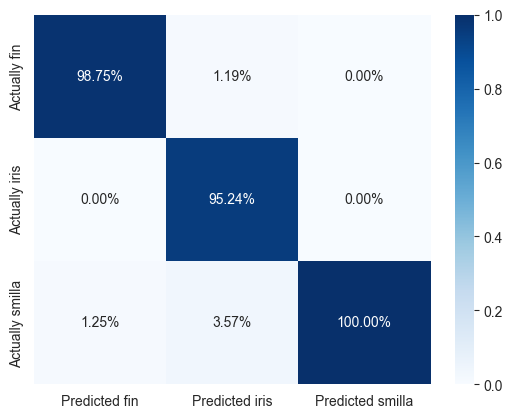

In [82]:
# Show recall in heat map
c_m = pd.DataFrame(confusion_matrix(y_true, y_pred), index=idx, columns=col)
sns.heatmap(c_m / np.sum(c_m), annot=True, fmt=".2%", cmap="Blues")

if SAVE:
    plt.savefig(f"{final_model}/pred_test_recall_heatmap_{v}.png")
plt.show()

### Overall classification heatmap

In [83]:
# Prepare classification report for heatmap visualization
cr = classification_report(y_true, y_pred, target_names=LABELS,
                           output_dict=True)
df_cr = pd.DataFrame.from_dict(cr)
df_cr.drop(index=["support"], axis=0, inplace=True)
df_cr.drop(columns=["macro avg", "weighted avg", "accuracy"], axis=1,
           inplace=True)
df_cr = df_cr.apply(lambda x: x * 100)

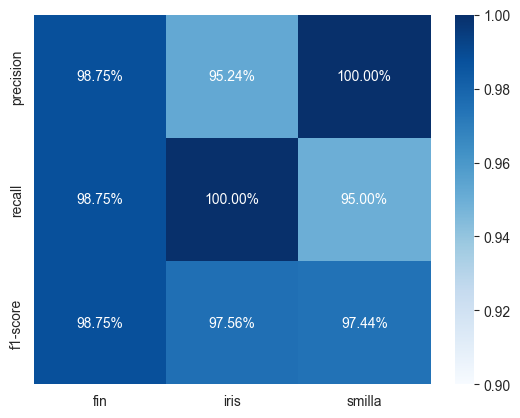

In [84]:
# Show precision in heat map
sns.heatmap(df_cr / 100, annot=True, fmt=".2%", cmap="Blues", vmin=0.9, vmax=1)
if SAVE:
    plt.savefig(f"{output_path}/pred_test_classification_heatmap_{v}.png")
plt.show()

### Images that were falsely classified

The following montage shows all misclassified classes, their actual classes, and the prediction probabilities.

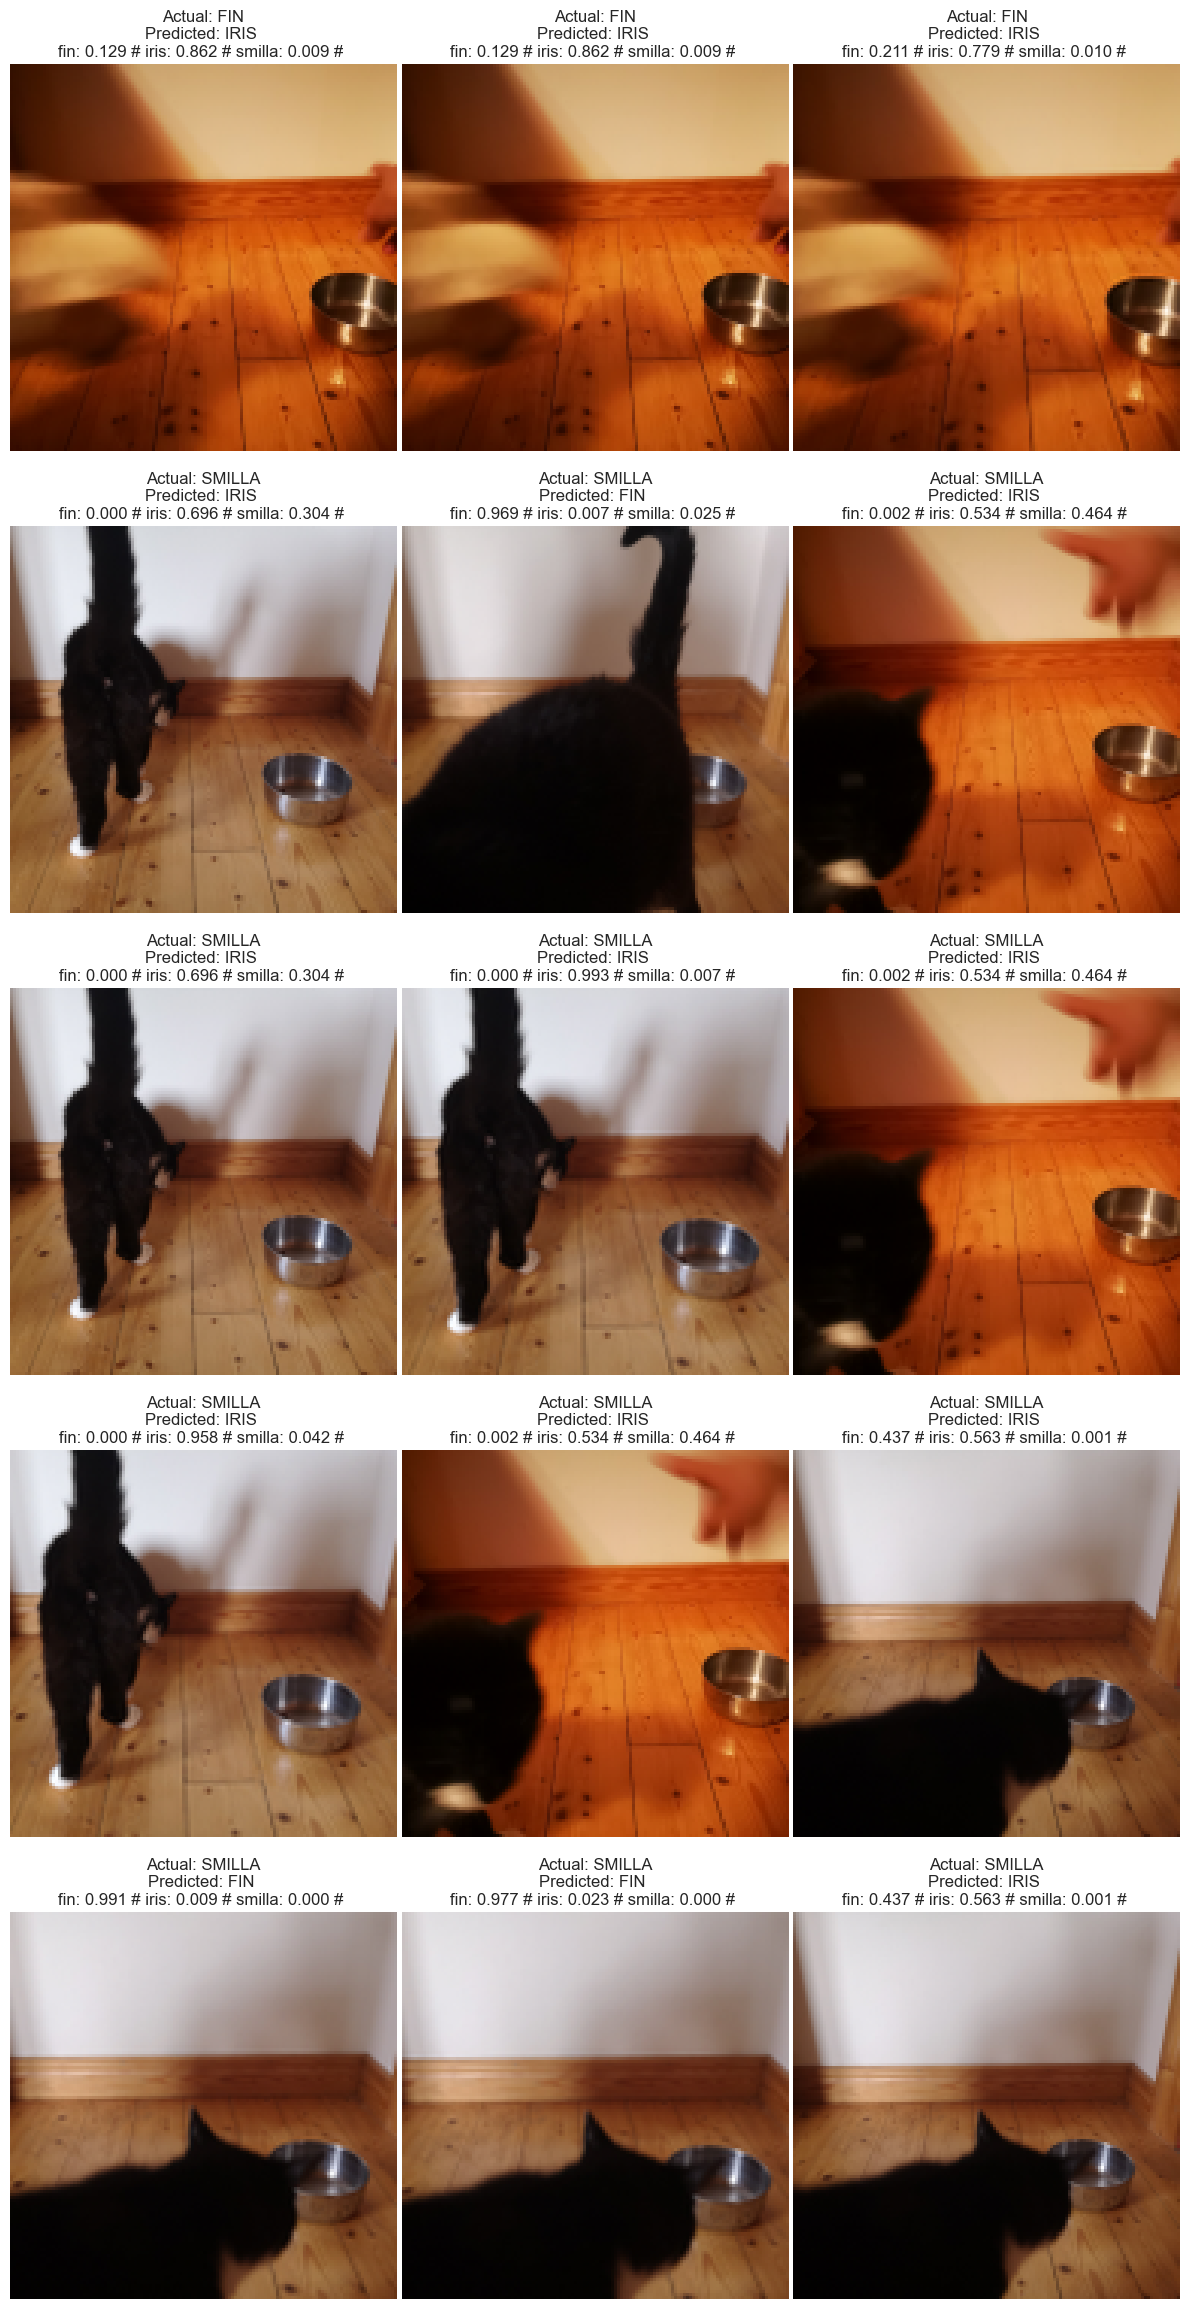

In [85]:
import itertools
# Compare both DataFrames
diff = y_true.compare(y_pred)
diff.sort_values(by=("", "self"), axis=0, inplace=True)
diff_label_pairs = np.array(diff)
diff_len = len(diff_label_pairs)
# Figure properties
nrows = diff_len // 3 + (1 if diff_len % 3 else 0)
coords = list(itertools.product(range(nrows), range(3)))[:diff_len]

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows * 5))
for ax in axes.flatten():
    ax.axis("off")
for coord, idx, labs in zip(coords, diff.index, diff_label_pairs):
    title_str = f"Actual: {labs[0].upper()}\nPredicted: {labs[1].upper()} \n"
    for i, cl in CLASS_DICT.items():
        title_str += f"{cl}: {y_pred_raw[idx][i]:.3f} # "
    axes[coord[0], coord[1]].set_title(title_str)
    axes[coord[0], coord[1]].imshow(X_test[idx])
    set_ticks(axes[coord[0], coord[1]])
plt.tight_layout(rect=[0, 0.05, 0.8, 0.98])
if SAVE:
    plt.savefig(f"{output_path}/pred_diff_test_montage_{v}.png")
plt.show()

### Test model with live data

In [86]:
from PIL.Image import UnidentifiedImageError


def save_live_data(path, shape):
    Xy_dict = {}
    dims = shape[1:3]
    for label in os.listdir(path):
        img_list = os.listdir(os.path.join(path, label))
        Xy_dict[label] = np.array([], dtype="int")

        print(f'\nImporting from label "{label}..."')
        progress_bar = show_progress(list_len=len(img_list))
        img_counter = 0
        errors = []

        for img_name in img_list:
            try:
                img = image.load_img(os.path.join(path, label, img_name))
            except UnidentifiedImageError as e:
                errors.append(f"{e} :: {img_name} >> skipped")
                continue
            if img.size != (dims):
                img = img.resize(dims, resample=Image.LANCZOS)
            img_resized = image.img_to_array(img)
            if img_resized.max() > 1:
                img_resized = img_resized / 255

            img_counter += 1
            Xy_dict[label] = np.append(Xy_dict[label], img_resized)

            print(next(progress_bar), end="")

        # Exhaust the generator
        try:
            rest = [p for p in progress_bar]
            print("".join(rest), end="")
        except StopIteration:
            pass

        print(f"{img_counter} images loaded")
        if errors:
            print_err("\n".join(errors))

        Xy_dict[label] = Xy_dict[label].reshape(shape)

    print("\nLive data loaded.")

    return Xy_dict

We import the live images from the live folder and save them in a dictionary.

In [87]:
live_path = os.path.join(cwd, "live_img")
X_y_live = save_live_data(live_path, INPUT_SHAPE)


Importing from label "fin..."
: ####################################################################################################|| 102 images loaded

Importing from label "iris..."
: ####################################################################################################|| 109 images loaded

Importing from label "smilla..."
: ####################################################################################################|| 145 images loaded

Live data loaded.



Shape of label fin: (102, 128, 128, 3)


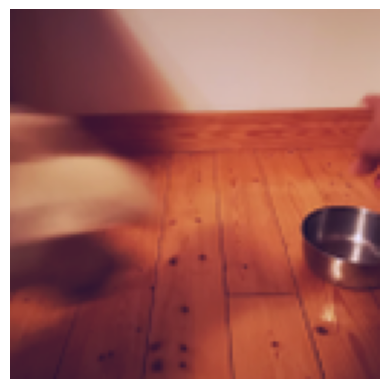

In [88]:

# Check if the images have been loaded correctly
rnd_label = random.choice(list(X_y_live.keys()))
print(f"\nShape of label {rnd_label}: {X_y_live.get(rnd_label).shape}")
plt.imshow(random.choice(X_y_live.get(rnd_label)))
plt.axis("off")
plt.show()

In [99]:
joblib.dump(X_y_live, f'{output_path}/X_y_live.pkl')

['d:\\Projekte\\Coding\\CodeInstitute\\PP5\\outputs/X_y_live.pkl']

In [90]:
from collections import Counter

sns.set_style("white")

X_live = np.array([])
y_true = np.array([])

for label in LABELS:
    X_live = np.append(X_live, X_y_live[label]).reshape(INPUT_SHAPE)
    y_true = np.append(y_true, [label] * len(X_y_live[label])).reshape(-1)


print(f"Live data shape: {X_live.shape}")
print("\nLive data stats: \n")

print(pd.DataFrame.from_dict(Counter(y_true), columns=["Amount"],
                             orient="index"))
print("")

###### Choose model type
#y_pred_raw = model.predict(X_live, verbose=0)
y_pred_raw = tflite_predict(X_live, *int_data)
######

# Convert the predictions into a DataFrame with class names
y_pred = pd.DataFrame(np.array([CLASS_DICT[i] 
                                for i in np.argmax(y_pred_raw, axis=1)]))

idx = [f"Actually {label}" for label in LABELS]
col = [f"Predicted {label}" for label in LABELS]

# Compare both DataFrames in a confusion matrix
conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred), index=idx,
                           columns=col)
# Create a classification report to see the model accuracy
class_report = classification_report(y_true, y_pred, target_names=LABELS)

print("\nConfusion matrix: \n")
print(conf_matrix)
print("\nClassification report: \n")
print(class_report)

if SAVE:
    joblib.dump(
        f"Confusion matrix:\n\n{conf_matrix.to_string()} \n\nClassification report:\n\n {class_report}",
        f"{final_model}/live_class_report_{v}.pkl",
    )

Live data shape: (356, 128, 128, 3)

Live data stats: 

        Amount
fin        102
iris       109
smilla     145


Confusion matrix: 

                 Predicted fin  Predicted iris  Predicted smilla
Actually fin               100               2                 0
Actually iris                0             106                 3
Actually smilla              0               7               138

Classification report: 

              precision    recall  f1-score   support

         fin       1.00      0.98      0.99       102
        iris       0.92      0.97      0.95       109
      smilla       0.98      0.95      0.97       145

    accuracy                           0.97       356
   macro avg       0.97      0.97      0.97       356
weighted avg       0.97      0.97      0.97       356



#### Live data recall heatmap

d:\Projekte\Coding\CodeInstitute\PP5\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


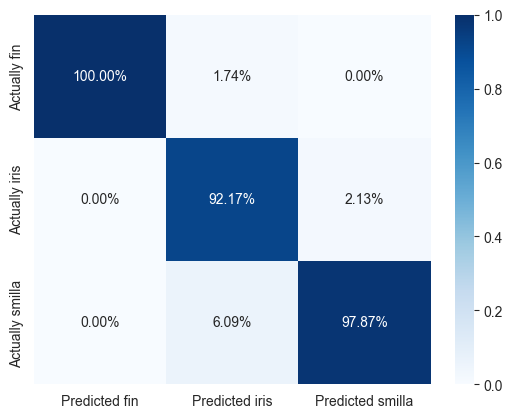

In [91]:
c_m = pd.DataFrame(confusion_matrix(y_true, y_pred), index=idx, columns=col)
sns.heatmap(c_m / np.sum(c_m), annot=True, fmt=".2%", cmap="Blues")

if SAVE:
    plt.savefig(f"{final_model}/pred_live_recall_heatmap_{v}.png")
plt.show()

#### Live data classification heatmap

In [93]:
# Prepare classification report for heatmap visualization
class_report = classification_report(
    y_true, y_pred, target_names=LABELS, output_dict=True
)
df_cr = pd.DataFrame.from_dict(class_report)
df_cr.drop(index=["support"], axis=0, inplace=True)
df_cr.drop(columns=["macro avg", "weighted avg", "accuracy"], axis=1,
           inplace=True)
df_cr = df_cr.apply(lambda x: x * 100)

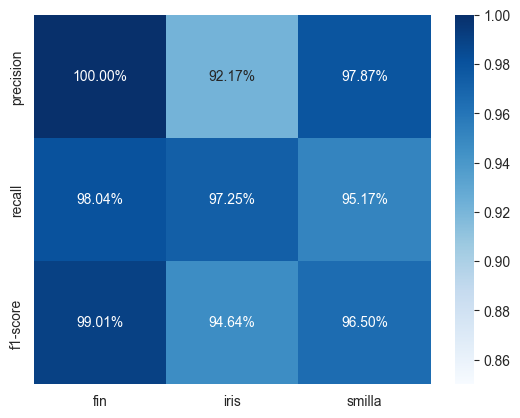

In [94]:
sns.heatmap(df_cr / 100, annot=True, fmt=".2%", cmap="Blues", vmin=0.85, vmax=1)

if SAVE:
    plt.savefig(f"{final_model}/pred_live_classification_heatmap_{v}.png")
plt.show()

###########################################################################
... Made predictions for 25 batches with 5 images per batch.
###########################################################################

Results for FIN:

Overall class prediction for all batches: FIN
Overall confidence for all batches: 0.9714000010490418


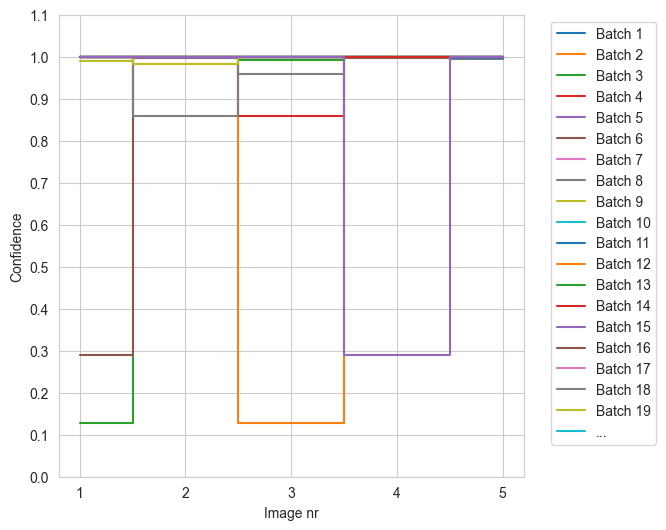

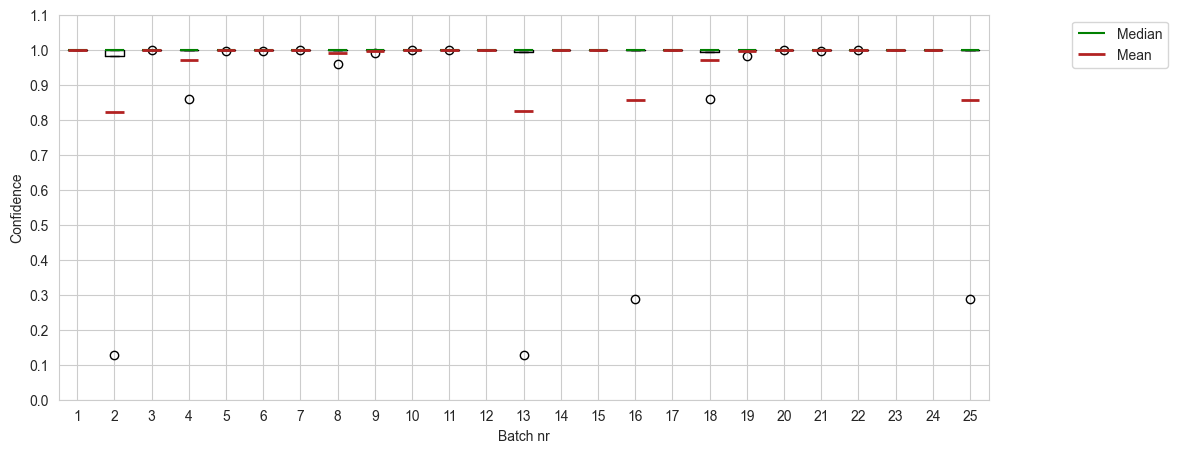

###########################################################################
... Made predictions for 25 batches with 5 images per batch.
###########################################################################

Results for IRIS:

Overall class prediction for all batches: IRIS
Overall confidence for all batches: 0.978800003528595


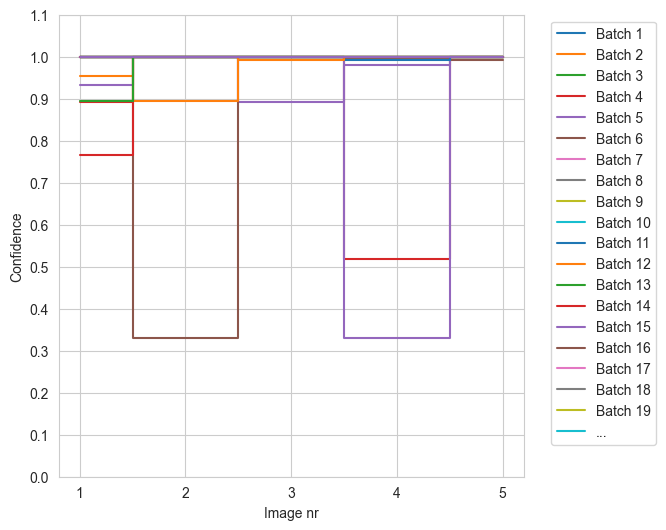

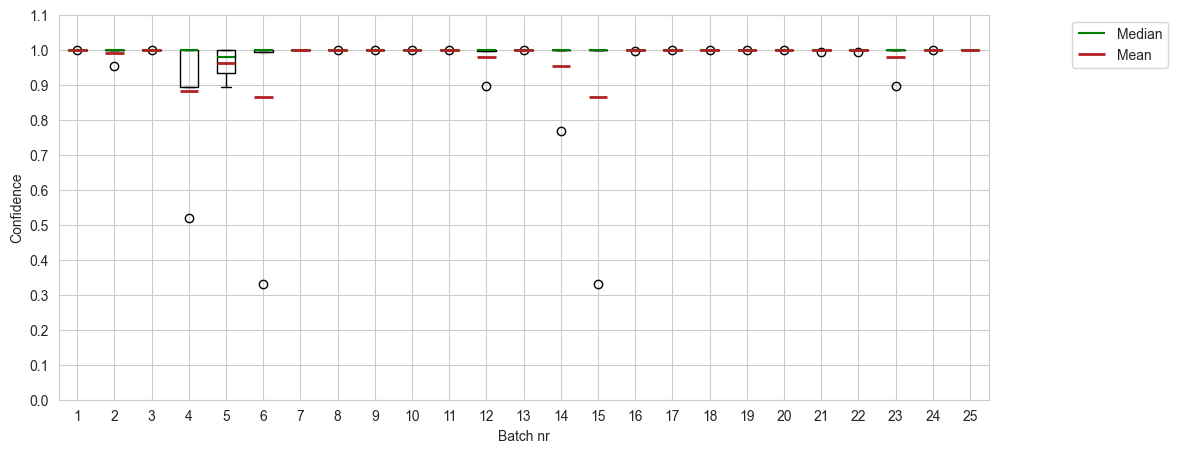

###########################################################################
... Made predictions for 25 batches with 5 images per batch.
###########################################################################

Results for SMILLA:

Overall class prediction for all batches: SMILLA
Overall confidence for all batches: 0.9484800076484681


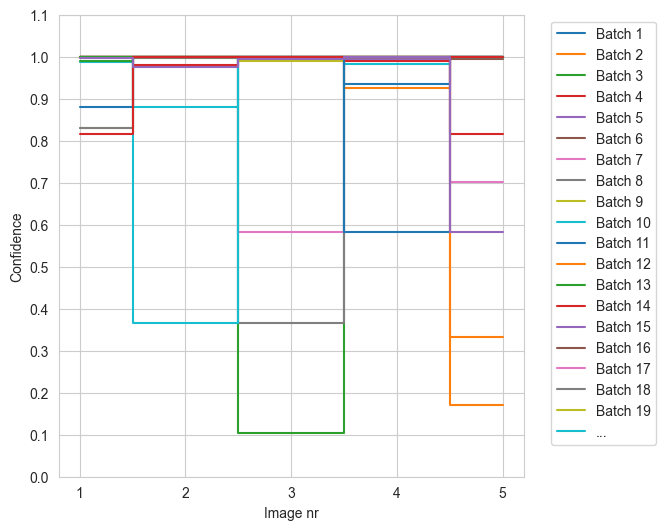

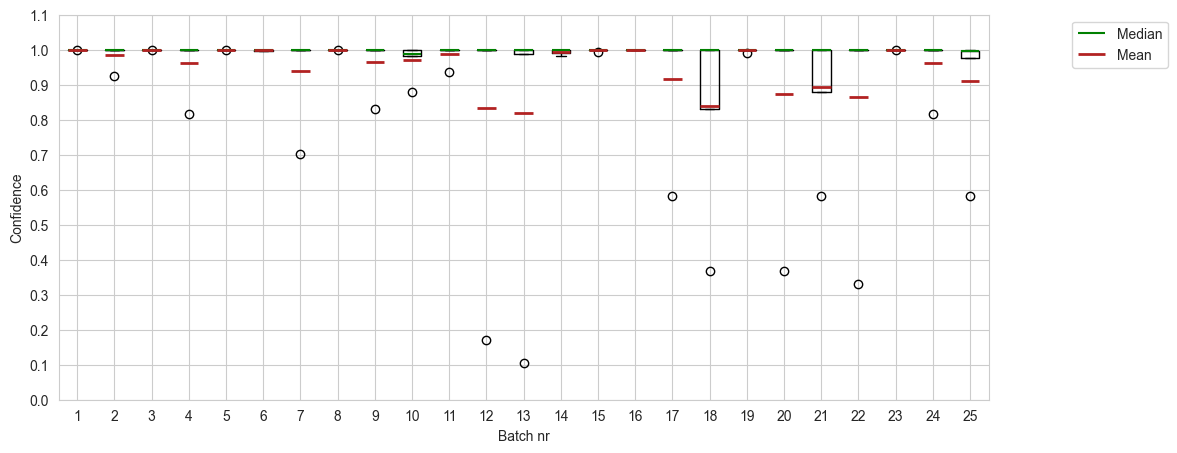

In [100]:
# Predict class by evaluating images in batches
from collections import Counter
import functools as ft


sns.set_style("whitegrid")

all_class_predictions = {"true": [], "pred": []}
single_errors = {}

# Go through each label in the live data dictionary
for label_name, img_set in X_y_live.items():
    conf_sum = 0
    
    # ADJUSTABLE PARAMETERS
    # How many separate batches should be predicted for each label?
    BATCH_AMOUNT = 25
    # How many images should be in one batch?
    SAMPLE_AMOUNT = 5

    fig, ax = plt.subplots(figsize=(6, 6))

    all_means = []
    all_vars = []
    batch_probas = []
    single_errors[label_name] = {}

    for batch_num in range(0, BATCH_AMOUNT):
        # For each batch: select a random sample
        img_sample = random.sample(range(0, len(img_set)), k=SAMPLE_AMOUNT)
        img_subset = img_set[[i for i in img_sample]]

        ####### Choose model
        #y_pred_raw = model.predict(img_subset, verbose=0)
        y_pred_raw = tflite_predict(img_subset, *int_data)
        #######
    
        # Create a DataFrame with all predicted class names for this batch
        y_pred = [CLASS_DICT[i] for i in np.argmax(y_pred_raw, axis=1)]

        # Calculate all class means based on each prediction for this label
        y_pred_means = np.around(np.mean(y_pred_raw, axis=0), 3)

        # Make final class prediction based on highest mean value
        confidence = max(y_pred_means)
        pred_class_idx = np.argmax(y_pred_means)
        class_guess = CLASS_DICT[pred_class_idx]

        current_batch_preds = y_pred_raw[:, LABELS.index(label_name)]

        # Plot a graph for the current batch showing confidence for each image
        ax.step(x=range(1, SAMPLE_AMOUNT + 1), y=current_batch_preds,
                where="mid")
        legend_str = '...' if BATCH_AMOUNT > 20 else ''
        ax.legend(
            [legend_str if legend_str and i == 20 else f"Batch {i}"
                        for i in range(1, min(BATCH_AMOUNT, 20) + 1)],
            loc="upper right",
            bbox_to_anchor=(0.7, 0.0, 0.6, 1),
        )
        
        # Save confidence values for each picture in each batch for the current label
        batch_probas.append(current_batch_preds)

        # Display the results for the current batch
        current_batch_errors = dict(Counter(
                                    [i for i in y_pred if i != label_name]))
        for key in current_batch_errors.keys():
            if single_errors[label_name].get(key):
                single_errors[label_name][key] += int(
                                                    current_batch_errors[key])
            else:
                single_errors[label_name][key] = int(current_batch_errors[key])

        # Save all predicted and true class names for later comparison
        all_class_predictions["true"].append(label_name)
        all_class_predictions["pred"].append(class_guess)

        # Sum up confidence for all batches
        conf_sum += confidence

    g = f"{Fore.GREEN}"
    r = f"{Fore.RESET}"
    print(
        f'{"#"*75}\n... Made predictions for {g}{BATCH_AMOUNT}{r} batches with'
        f' {g}{SAMPLE_AMOUNT}{r} images per batch.\n{"#"*75}'
    )
    print(f"\nResults for {g}{label_name.upper()}{r}:\n")
    maj_class = Counter(
        all_class_predictions["pred"][-1 * BATCH_AMOUNT :]).most_common(1)[0][0]
    print(f"Overall class prediction for all batches: "
          f"{g}{maj_class.upper()}{r}")
    print(f"Overall confidence for all batches: "
          f"{g}{conf_sum/BATCH_AMOUNT}{r}")

    plt.yticks(np.arange(0, 1.2, 0.1))
    plt.xticks(np.arange(1, SAMPLE_AMOUNT + 1, 1))
    plt.ylabel("Confidence")
    plt.xlabel("Image nr")
    if SAVE:
        plt.savefig(f"{final_model}/live_class_img_probas_{label_name}_{v}.png",
                    bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 5))
    for c, x in enumerate(batch_probas, start=1):
        plot = ax.boxplot(
            x,
            positions=[c],
            widths=0.5,
            showmeans=True,
            meanline=True,
            meanprops={"linestyle": "-", "color": "firebrick", "linewidth": 2},
            medianprops={"linestyle": "-", "color": "green", "linewidth": 1.5},
        )
        ax.legend(
            [plot["medians"][0], plot["means"][0]],
            ["Median", "Mean"],
            loc="upper right",
            bbox_to_anchor=(0.6, 0.0, 0.6, 1),
        )

        ax.set_ylabel("Confidence")
        ax.set_xlabel("Batch nr")
    plt.yticks(np.arange(0, 1.2, 0.1))
    plt.xticks(np.arange(1, BATCH_AMOUNT + 1, 1))

    if SAVE:
        plt.savefig(
            f"{final_model}/live_class_batch_probas_"
            f"{label_name}_{v}_{BATCH_AMOUNT}_{SAMPLE_AMOUNT}.png",
            bbox_inches='tight')
    plt.show()


In [101]:

df_errors = pd.DataFrame.from_dict(single_errors)
df_errors.rename_axis(index=("Misclassified as"), inplace=True)
print(f"Analyzed {SAMPLE_AMOUNT*BATCH_AMOUNT} images per label in total\n")
print(f"\nErrors during {g}individual{r} image classification:\n")
style_dataframe(df_errors)

idx = [f"Actually {label}" for label in LABELS]
col = [f"Predicted {label}" for label in LABELS]

# Compare both DataFrames in a confusion matrix
conf_matrix = pd.DataFrame(
    confusion_matrix(all_class_predictions["true"],
                     all_class_predictions["pred"]), 
    index=idx,
    columns=col,
)

# Create a classification report to see the model accuracy
class_report = classification_report(
    all_class_predictions["true"], all_class_predictions["pred"],
    target_names=LABELS
)

print(
    f"\n\nErrors during {g}batch{r} classification:\n\nConfusion matrix: \n "
    f"{conf_matrix}\n\nClassification report: \n\n{class_report}"
)

report = (
    f"\nErrors during {g}individual{r} image classification:\n{df_errors}"
    f"\n\nErrors during {g}batch{r} classification:\n\nConfusion matrix: \n "
    f"{conf_matrix}\n\nClassification report: \n\n{class_report}"
)

if SAVE:
    joblib.dump(report,
                f"{final_model}/live_class_report_batches_{v}_50_15.pkl")

Analyzed 125 images per label in total


Errors during individual image classification:

Misclassified as          FIN         IRIS       SMILLA
----------------------------------------------------------------------
iris                      4.0          nan          5.0
smilla                    nan          2.0          nan


Errors during batch classification:

Confusion matrix: 
                  Predicted fin  Predicted iris  Predicted smilla
Actually fin                25               0                 0
Actually iris                0              25                 0
Actually smilla              0               0                25

Classification report: 

              precision    recall  f1-score   support

         fin       1.00      1.00      1.00        25
        iris       1.00      1.00      1.00        25
      smilla       1.00      1.00      1.00        25

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
w

### Simulate real-world application

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[0.99 0.01 0.  ]

##############################
Classification complete: fin
 Confidence: 0.99, predictedclass: fin
##############################



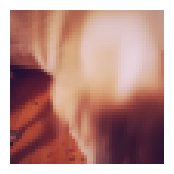

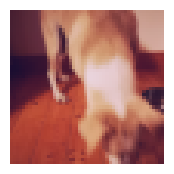

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



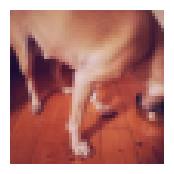

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[0.95 0.05 0.  ]

##############################
Classification complete: fin
 Confidence: 0.95, predictedclass: fin
##############################



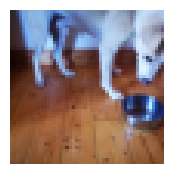

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



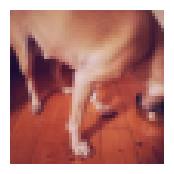

Current mean of the trial: 
[0.99 0.01 0.  ]

##############################
Classification complete: fin
 Confidence: 0.99, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



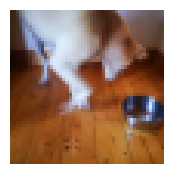

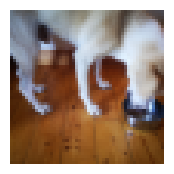

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



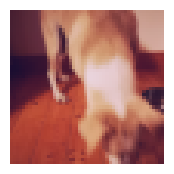

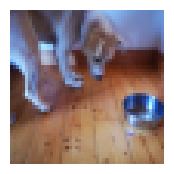

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



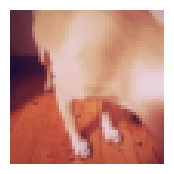

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



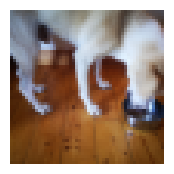

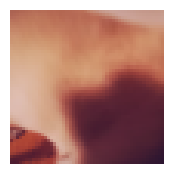

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



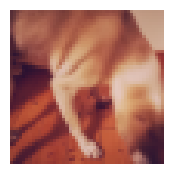

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



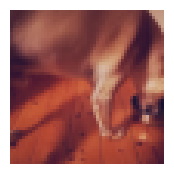

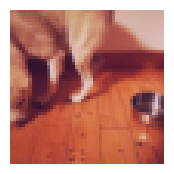

Current mean of the trial: 
[0.99 0.01 0.  ]

##############################
Classification complete: fin
 Confidence: 0.99, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



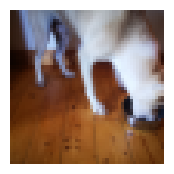

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[0.98 0.02 0.  ]

##############################
Classification complete: fin
 Confidence: 0.98, predictedclass: fin
##############################



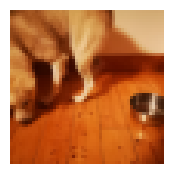

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



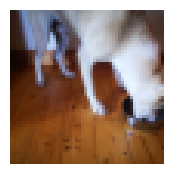

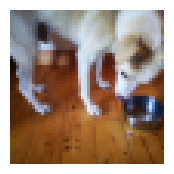

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



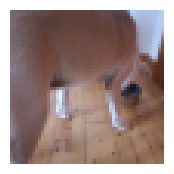

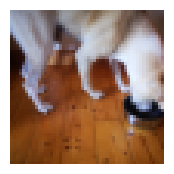

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



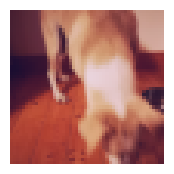

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[0.76 0.22 0.01]
--- Unsure yet: current confidence: 0.76, tending towards class: fin

Current mean of the trial: 
[0.82 0.17 0.01]

##############################
Classification complete: fin
 Confidence: 0.82, predictedclass: fin
##############################



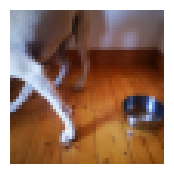

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



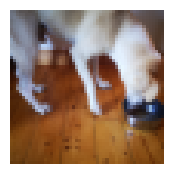

Current mean of the trial: 
[0.99 0.01 0.  ]

##############################
Classification complete: fin
 Confidence: 0.99, predictedclass: fin
##############################



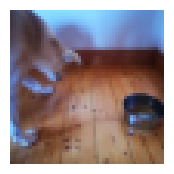

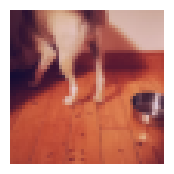

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



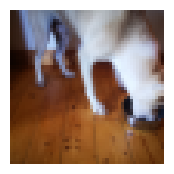

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



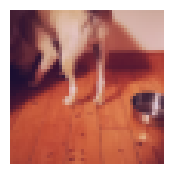

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[0.99 0.01 0.  ]

##############################
Classification complete: fin
 Confidence: 0.99, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



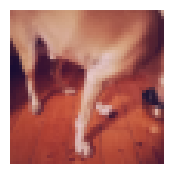

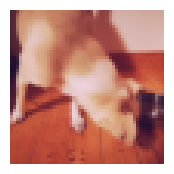

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[0.92 0.01 0.08]

##############################
Classification complete: fin
 Confidence: 0.92, predictedclass: fin
##############################



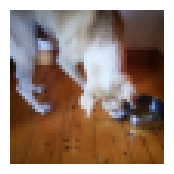

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################

Current mean of the trial: 
[1. 0. 0.]

##############################
Classification complete: fin
 Confidence: 1.00, predictedclass: fin
##############################



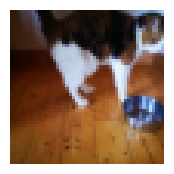

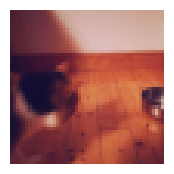

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



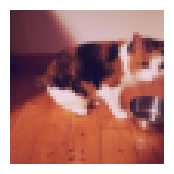

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



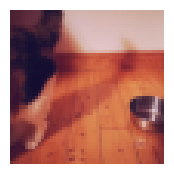

Current mean of the trial: 
[0.   0.98 0.02]

##############################
Classification complete: iris
 Confidence: 0.98, predictedclass: iris
##############################



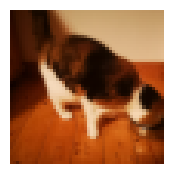

Current mean of the trial: 
[0.08 0.9  0.02]

##############################
Classification complete: iris
 Confidence: 0.90, predictedclass: iris
##############################



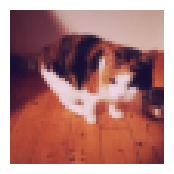

Current mean of the trial: 
[0.   0.99 0.01]

##############################
Classification complete: iris
 Confidence: 0.99, predictedclass: iris
##############################



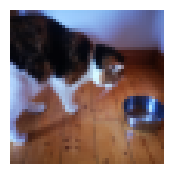

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



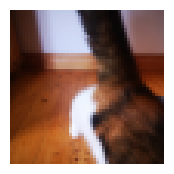

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0.   0.99 0.01]

##############################
Classification complete: iris
 Confidence: 0.99, predictedclass: iris
##############################



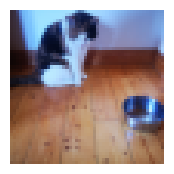

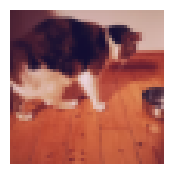

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



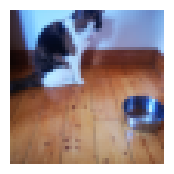

Current mean of the trial: 
[0.   0.97 0.03]

##############################
Classification complete: iris
 Confidence: 0.97, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



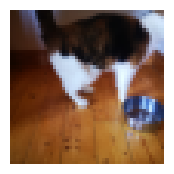

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



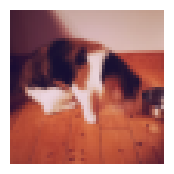

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0.   0.94 0.06]

##############################
Classification complete: iris
 Confidence: 0.94, predictedclass: iris
##############################



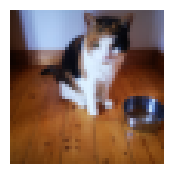

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



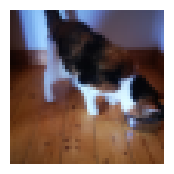

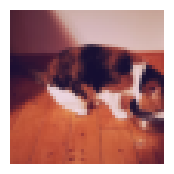

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



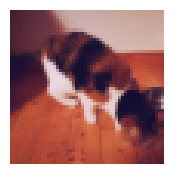

Current mean of the trial: 
[0.   0.97 0.03]

##############################
Classification complete: iris
 Confidence: 0.97, predictedclass: iris
##############################



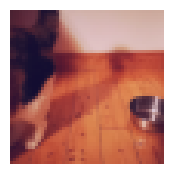

Current mean of the trial: 
[0.   0.97 0.03]

##############################
Classification complete: iris
 Confidence: 0.97, predictedclass: iris
##############################



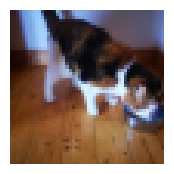

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



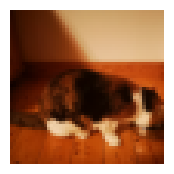

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0.   0.78 0.22]
--- Unsure yet: current confidence: 0.78, tending towards class: iris

Current mean of the trial: 
[0.   0.82 0.18]

##############################
Classification complete: iris
 Confidence: 0.82, predictedclass: iris
##############################



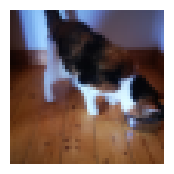

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



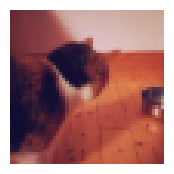

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



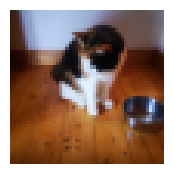

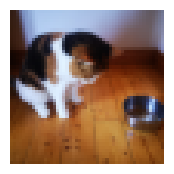

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



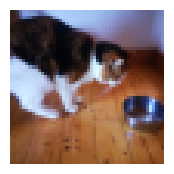

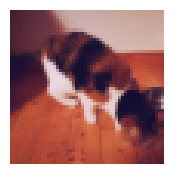

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



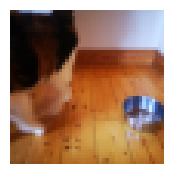

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



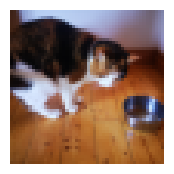

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0.08 0.92 0.  ]

##############################
Classification complete: iris
 Confidence: 0.92, predictedclass: iris
##############################



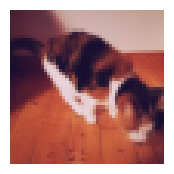

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0.   0.81 0.19]

##############################
Classification complete: iris
 Confidence: 0.81, predictedclass: iris
##############################



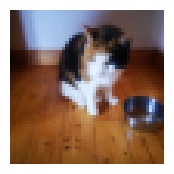

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



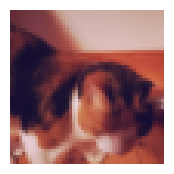

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0.   0.82 0.18]

##############################
Classification complete: iris
 Confidence: 0.82, predictedclass: iris
##############################



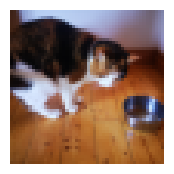

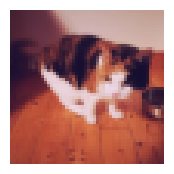

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



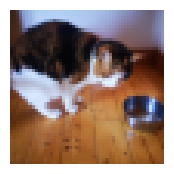

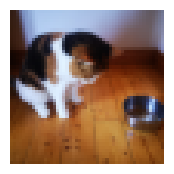

Current mean of the trial: 
[0.   0.96 0.04]

##############################
Classification complete: iris
 Confidence: 0.96, predictedclass: iris
##############################

Current mean of the trial: 
[0. 1. 0.]

##############################
Classification complete: iris
 Confidence: 1.00, predictedclass: iris
##############################



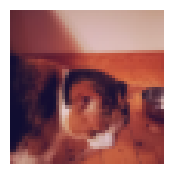

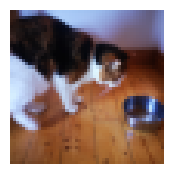

Current mean of the trial: 
[0.   0.81 0.19]

##############################
Classification complete: iris
 Confidence: 0.81, predictedclass: iris
##############################

Current mean of the trial: 
[0.   0.84 0.16]

##############################
Classification complete: iris
 Confidence: 0.84, predictedclass: iris
##############################

Current mean of the trial: 
[0.01 0.33 0.66]
--- Unsure yet: current confidence: 0.66, tending towards class: smilla

Current mean of the trial: 
[0.01 0.25 0.75]
--- Unsure yet: current confidence: 0.75, tending towards class: smilla



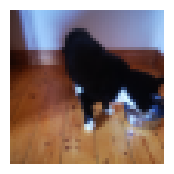

Current mean of the trial: 
[0.  0.2 0.8]

##############################
Classification complete: smilla
 Confidence: 0.80, predictedclass: smilla
##############################



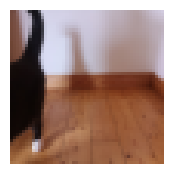

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################



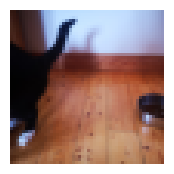

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################

Current mean of the trial: 
[0.   0.01 0.99]

##############################
Classification complete: smilla
 Confidence: 0.99, predictedclass: smilla
##############################

Current mean of the trial: 
[0.   0.06 0.94]

##############################
Classification complete: smilla
 Confidence: 0.94, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################

Current mean of the trial: 
[0.   0.07 0.93]

##############################
Classification complete: s

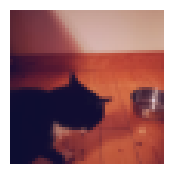

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################



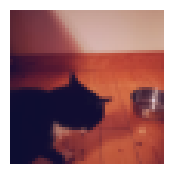

Current mean of the trial: 
[0.   0.14 0.86]

##############################
Classification complete: smilla
 Confidence: 0.86, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################

Current mean of the trial: 
[0.01 0.23 0.77]
--- Unsure yet: current confidence: 0.77, tending towards class: smilla

Current mean of the trial: 
[0.   0.17 0.83]

##############################
Classification complete: smilla
 Confidence: 0.83, predictedclass: smilla
#################

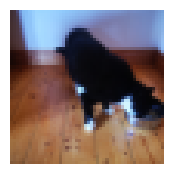

Current mean of the trial: 
[0.   0.14 0.86]

##############################
Classification complete: smilla
 Confidence: 0.86, predictedclass: smilla
##############################

Current mean of the trial: 
[0.  0.1 0.9]

##############################
Classification complete: smilla
 Confidence: 0.90, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################



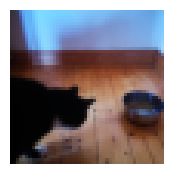

Current mean of the trial: 
[0.   0.07 0.93]

##############################
Classification complete: smilla
 Confidence: 0.93, predictedclass: smilla
##############################



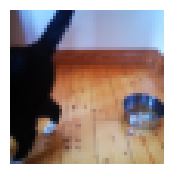

Current mean of the trial: 
[0.   0.02 0.98]

##############################
Classification complete: smilla
 Confidence: 0.98, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################



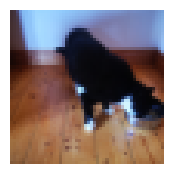

Current mean of the trial: 
[0.01 0.   0.98]

##############################
Classification complete: smilla
 Confidence: 0.98, predictedclass: smilla
##############################



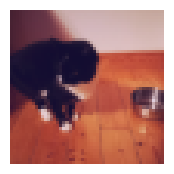

Current mean of the trial: 
[0.   0.07 0.93]

##############################
Classification complete: smilla
 Confidence: 0.93, predictedclass: smilla
##############################



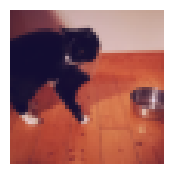

Current mean of the trial: 
[0.   0.25 0.75]
--- Unsure yet: current confidence: 0.75, tending towards class: smilla



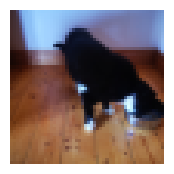

Current mean of the trial: 
[0.   0.42 0.58]
--- Unsure yet: current confidence: 0.58, tending towards class: smilla

Current mean of the trial: 
[0.   0.33 0.67]
--- Unsure yet: current confidence: 0.67, tending towards class: smilla

Current mean of the trial: 
[0.   0.28 0.72]
--- Unsure yet: current confidence: 0.72, tending towards class: smilla

Current mean of the trial: 
[0.   0.24 0.76]
--- Unsure yet: current confidence: 0.76, tending towards class: smilla

Current mean of the trial: 
[0.   0.21 0.79]
--- Unsure yet: current confidence: 0.79, tending towards class: smilla

Current mean of the trial: 
[0.   0.18 0.82]

##############################
Classification complete: smilla
 Confidence: 0.82, predictedclass: smilla
##############################

Current mean of the trial: 
[0.   0.22 0.78]
--- Unsure yet: current confidence: 0.78, tending towards class: smilla

Current mean of the trial: 
[0.   0.17 0.83]

##############################
Classification complete: smilla


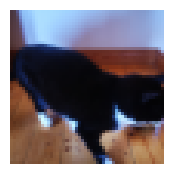

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################

Current mean of the trial: 
[0.01 0.   0.99]

##############################
Classification complete: smilla
 Confidence: 0.99, predictedclass: smilla
##############################



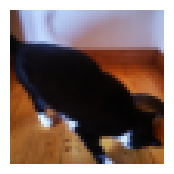

Current mean of the trial: 
[0.01 0.   0.99]

##############################
Classification complete: smilla
 Confidence: 0.99, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################

Current mean of the trial: 
[0.   0.21 0.79]
--- Unsure yet: current confidence: 0.79, tending towards class: smilla



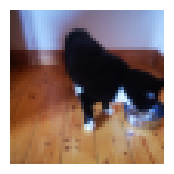

Current mean of the trial: 
[0.   0.16 0.84]

##############################
Classification complete: smilla
 Confidence: 0.84, predictedclass: smilla
##############################



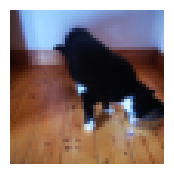

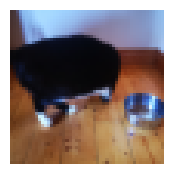

Current mean of the trial: 
[0.   0.06 0.94]

##############################
Classification complete: smilla
 Confidence: 0.94, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################

Current mean of the trial: 
[0.   0.07 0.93]

##############################
Classification complete: smilla
 Confidence: 0.93, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################



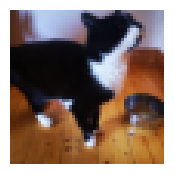

Current mean of the trial: 
[0.   0.58 0.42]
--- Unsure yet: current confidence: 0.58, tending towards class: iris

Current mean of the trial: 
[0.   0.43 0.57]
--- Unsure yet: current confidence: 0.57, tending towards class: smilla

Current mean of the trial: 
[0.   0.35 0.65]
--- Unsure yet: current confidence: 0.65, tending towards class: smilla

Current mean of the trial: 
[0.   0.29 0.71]
--- Unsure yet: current confidence: 0.71, tending towards class: smilla

Current mean of the trial: 
[0.   0.25 0.75]
--- Unsure yet: current confidence: 0.75, tending towards class: smilla

Current mean of the trial: 
[0.   0.22 0.78]
--- Unsure yet: current confidence: 0.78, tending towards class: smilla

Current mean of the trial: 
[0.   0.19 0.81]

##############################
Classification complete: smilla
 Confidence: 0.81, predictedclass: smilla
##############################



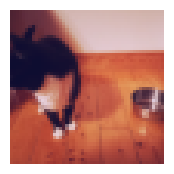

Current mean of the trial: 
[0.  0.6 0.4]
--- Unsure yet: current confidence: 0.60, tending towards class: iris

Current mean of the trial: 
[0.   0.45 0.55]
--- Unsure yet: current confidence: 0.55, tending towards class: smilla

Current mean of the trial: 
[0.   0.36 0.64]
--- Unsure yet: current confidence: 0.64, tending towards class: smilla

Current mean of the trial: 
[0.  0.3 0.7]
--- Unsure yet: current confidence: 0.70, tending towards class: smilla



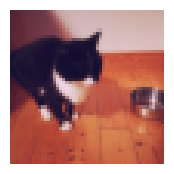

Current mean of the trial: 
[0.   0.26 0.74]
--- Unsure yet: current confidence: 0.74, tending towards class: smilla

Current mean of the trial: 
[0.   0.22 0.78]
--- Unsure yet: current confidence: 0.78, tending towards class: smilla

Current mean of the trial: 
[0.  0.2 0.8]

##############################
Classification complete: smilla
 Confidence: 0.80, predictedclass: smilla
##############################



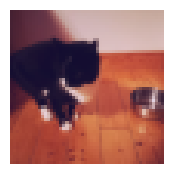

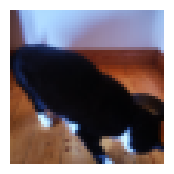

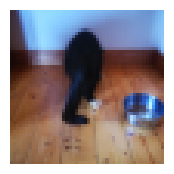

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################



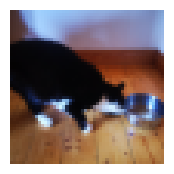

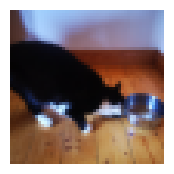

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################



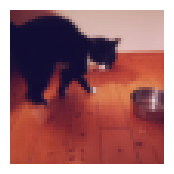

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################



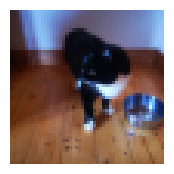

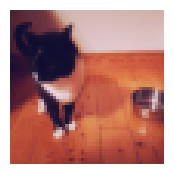

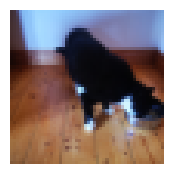

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################



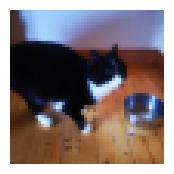

Current mean of the trial: 
[0.   0.32 0.68]
--- Unsure yet: current confidence: 0.68, tending towards class: smilla

Current mean of the trial: 
[0.   0.24 0.76]
--- Unsure yet: current confidence: 0.76, tending towards class: smilla

Current mean of the trial: 
[0.   0.21 0.79]
--- Unsure yet: current confidence: 0.79, tending towards class: smilla

Current mean of the trial: 
[0.   0.17 0.83]

##############################
Classification complete: smilla
 Confidence: 0.83, predictedclass: smilla
##############################



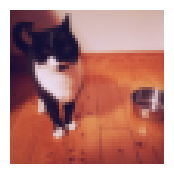

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################



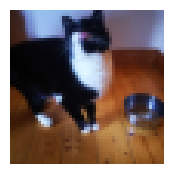

Current mean of the trial: 
[0.   0.32 0.68]
--- Unsure yet: current confidence: 0.68, tending towards class: smilla

Current mean of the trial: 
[0.   0.24 0.76]
--- Unsure yet: current confidence: 0.76, tending towards class: smilla

Current mean of the trial: 
[0.01 0.19 0.8 ]

##############################
Classification complete: smilla
 Confidence: 0.80, predictedclass: smilla
##############################

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################



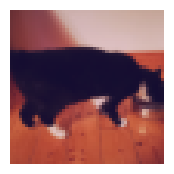

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################



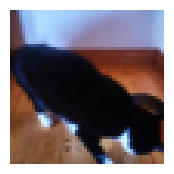

Current mean of the trial: 
[0. 0. 1.]

##############################
Classification complete: smilla
 Confidence: 1.00, predictedclass: smilla
##############################



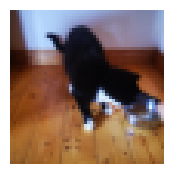

Current mean of the trial: 
[0.   0.32 0.68]
--- Unsure yet: current confidence: 0.68, tending towards class: smilla

Current mean of the trial: 
[0.   0.24 0.76]
--- Unsure yet: current confidence: 0.76, tending towards class: smilla

Current mean of the trial: 
[0.  0.2 0.8]

##############################
Classification complete: smilla
 Confidence: 0.80, predictedclass: smilla
##############################



In [106]:
from skimage.transform import resize

sns.set_style("white")


# Set MIX_MODE to True to confuse the model with a stream of mixed images
MIX_MODE = False

# Generator either produces random images from one specific label
# or random images from a random label
def X_gen(X, label=None, mix=False):
    if mix:
        while True:
            rand_lbl = random.choice(LABELS)
            rand_idx = random.randint(0, len(X[rand_lbl]) - 1)
            yield X[rand_lbl][rand_idx], rand_lbl
    else:
        while True:
            rand_idx = random.randint(0, len(X[label]) - 1)
            yield X[label][rand_idx], None


def show_reel(img):
    """Show image reel"""

    # Show only about 20% of images to speed up the execution
    if random.random() > 0.8:
        img_small = resize(img, (50, 50))
        plt.figure(figsize=(2, 2))
        plt.axis("off")
        plt.imshow(img_small)
        plt.show()

result = {}

# ADJUSTABLE PARAMETERS
# Amount of trials for each label
TRIAL_AMOUNT = 50
# Minimum amount of images to be evaluated as one batch; a too low number can
# lead to misclassification due to a high-confidence error early on
IMG_MIN = 3
# Minimum accepted confidence threshold
MIN_CONFIDENCE = 80
# Max amount of attempts after which the current trial is aborted and the next 
# trial started
MAX_ATTEMPTS = 15


if MIX_MODE:
    loop_params = ["run 1", "run 2", "run 3"]
else:
    loop_params = LABELS

for label in loop_params:
    trial_results = []

    # Initialize random generator
    xgen = X_gen(X_y_live, label, MIX_MODE)

    for t in range(TRIAL_AMOUNT):
        attempt_count = 0
        trial_probas = []
        trial_labels = []

        # Run trial until the desired confidence threshold has been reached
        # or until the attempt count has reached max attempts.
        while True:
            attempt_count += 1

            img, true_class = next(xgen)

            # --------- Uncomment to see a reel of currently evaluated images
            show_reel(img)
            # ---------

            # Prepare image and use model to predict a class
            img = np.expand_dims(img, axis=0)

            ##### CHOOSE MODEL
            #y_pred_sg = model.predict(img, verbose=3)
            y_pred_sg = tflite_predict(img, *int_data)
            #####

            # Keep track of all probabilities in the current trial
            trial_probas.append(y_pred_sg)

            if MIX_MODE:
                trial_labels.append(true_class)

            if attempt_count >= IMG_MIN:
                print("Current mean of the trial: ")
                cur_mean = np.round(np.mean(trial_probas, axis=0), 2).flatten()
                print(cur_mean)
                fav_class = np.argmax(cur_mean)

                if MIX_MODE:
                    print(
                        f"Model thinks it's {CLASS_DICT[fav_class]}, it's "
                        f"{true_class}"
                    )

                if (
                    cur_mean[fav_class] > MIN_CONFIDENCE / 100
                    or attempt_count > MAX_ATTEMPTS
                ):
                    add_info = ""
                    if attempt_count > MAX_ATTEMPTS:
                        if MIX_MODE:
                            add_info = f"{f'maj. {Counter(trial_labels).most_common(1)[0]}/{len(trial_labels)}':>20}"
                        print(
                            f'\n{"#"*30}\nCancelling classification attempt '
                            f'after {MAX_ATTEMPTS} trials.\n'
                            f'Confidence: {cur_mean[fav_class]:.2f}, tending '
                            f'towards class: {CLASS_DICT[fav_class]}\n{"#"*30}\n'
                        )
                        trial_results.append(
                            [
                                np.nan,
                                f"{f'{CLASS_DICT[fav_class]}?':<13} {add_info}",
                                cur_mean[fav_class],
                            ]
                        )
                        break
                    else:
                        if MIX_MODE:
                            maj_class = Counter(trial_labels).most_common(1)[0]
                            trial_results.append(
                                [
                                    attempt_count,
                                    f"{CLASS_DICT[fav_class]} {maj_class}/"
                                    f"{len(trial_labels)}",
                                    cur_mean[fav_class],
                                ]
                            )
                            add_info = f", majority class: {maj_class}"
                        else:
                            trial_results.append(
                                [
                                    attempt_count,
                                    CLASS_DICT[fav_class],
                                    cur_mean[fav_class],
                                ]
                            )

                        print(
                            f'\n{"#"*30}\nClassification complete: '
                            f'{CLASS_DICT[fav_class]}\n '
                            f'Confidence: {cur_mean[fav_class]:.2f}, predicted'
                            f'class: {CLASS_DICT[fav_class]}{add_info}\n'
                            f'{"#"*30}\n'
                        )
                        break

                else:
                    print(
                        f"--- Unsure yet: current confidence: {cur_mean[fav_class]:.2f}, tending towards class: {CLASS_DICT[fav_class]}\n"
                    )

    result[label] = trial_results

Log the results of the trials.

In [107]:
for label in loop_params:
    column_list = ["-- Attempts --", "------- Pred. class -------", "-- Confidence --"]
    new_dict = {
        (f"Looping through label {label}:", c): np.array(result[label])[..., i].tolist()
        for i, c in enumerate(column_list)
    }
    df = pd.DataFrame.from_dict(new_dict, orient="index").transpose()
    df.columns = pd.MultiIndex.from_tuples(list(new_dict.keys()))
    print(df)
    print("\n\n")

    with open(f'{output_path}/100trials_'
              f'{label}_{TRIAL_AMOUNT}_{MIN_CONFIDENCE}_x_b_1.txt', 'w+') as f:
        f.write(df.to_string())

   Looping through label fin:                                             
               -- Attempts -- ------- Pred. class ------- -- Confidence --
0                           3                         fin              1.0
1                           3                         fin             0.99
2                           3                         fin              1.0
3                           3                         fin              1.0
4                           3                         fin              1.0
5                           3                         fin              1.0
6                           3                         fin             0.95
7                           3                         fin              1.0
8                           3                         fin              1.0
9                           3                         fin              1.0
10                          3                         fin              1.0
11                       